# Interactive UMAP-explorer

## Imports & Definitions

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import topo as tp
from scipy.sparse import csr_matrix

import plotly.graph_objects as go
from ipywidgets import widgets, VBox, HBox, Layout
from IPython.display import display
from scipy.spatial import ConvexHull
from scipy.ndimage import gaussian_filter
import tifffile
import matplotlib.pyplot as plt
%matplotlib widget
import ipympl
from typing import List, Tuple

# DataProcessor for use with apoDet-Output
class DataProcessor:
    def __init__(self, features_df_path):
        """Initializes the processor, extracts features, and sets up UMAP."""
        print("Loading FeaturesDF")
        self.df = pd.read_json(
                features_df_path,
                orient='records',
                lines=True
        ) # Main DataFrame ('track_id', 't', 'y', 'x', 'embedding', 'path', 'filename')
        print("\tFeatures loaded.")

        print("Extracting features from 'embedding' column...")
        self.feats = np.array(self.df['embedding'].tolist())
        
        # UMAP setup
        try:
            from cuml import UMAP as GPU_UMAP
            self.UMAP_Class = GPU_UMAP
            print("Using GPU-accelerated UMAP (cuML)")
        except ImportError:
            self.UMAP_Class = CPU_UMAP
            print("cuML not found, falling back to CPU UMAP")

    def apply_phenotype(self, metadata_path):
        """
        Requires metadata csv with columns: ['track_id', 't', 'class']
        """
        metadata = pd.read_csv(metadata_path)

        df_meta = metadata.rename(columns={'t_start': 't'})
        
        # 2. Merge on track_id and t
        df_combined = pd.merge(
            self.df, 
            df_meta[['track_id', 't', 'class']], 
            on=['track_id', 't'], 
            how='left'
        )
        
        df_combined = df_combined.rename(columns={'class': 'phenotype'})

        return df_combined
        



    def compute_embedding(self, topometry=False, n_neighbors=50, n_components=2, min_dist=0.1, random_state=42) -> np.ndarray:
        """
        Compute 2D embedding using UMAP, optionally enhanced with TopOMetry.
        
        Parameters
        ----------
        feats : np.ndarray or pd.DataFrame
            Feature matrix (cells x features)
        topometry : bool
            Whether to apply TopOMetry graph enhancement first
        n_neighbors : int
            Number of neighbors for UMAP or TopOMetry graph
        n_components : int
            Number of UMAP dimensions
        min_dist : float
            UMAP min_dist parameter
        random_state : int
            Random seed for reproducibility
            
        Returns
        -------
        embedding : np.ndarray
            2D embedding of shape (n_samples, n_components)
        """
        if topometry:
            print("Applying TopOMetry to enhance graph...")
            tg = tp.TopOGraph(
                n_eigs=50,
                base_knn=n_neighbors,
                graph_knn=n_neighbors,
                random_state=random_state,
                n_jobs=-1
            )
            tg.fit(self.feats)
            tg.transform(self.feats)
            
            # Extract the first kernel graph (similarity matrix)
            kernel_obj = list(tg.GraphKernelDict.values())[0]
    
            # Convert to distance: D = 1 - normalized_K
            K = kernel_obj.K.astype(float)
            # normalize to [0,1] if not already
            K = K / K.max()
            
            D = K.copy()                  # copy sparse matrix
            D.data = 1.0 - D.data         # subtract only the non-zero entries
            D.setdiag(0)
            D.eliminate_zeros() # Good practice to clean up
            data_for_umap = D.toarray()
            metric = "precomputed"
            UMAP_Class = self.UMAP_Class # TopOMetry typically forces CPU UMAP
        else:
            data_for_umap = self.feats
            metric = "cosine"
            UMAP_Class = self.UMAP_Class # Use the best available UMAP class
            
        reducer = self.UMAP_Class(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric=metric,
            random_state=random_state
        )
        embedding = reducer.fit_transform(data_for_umap)
        
        return embedding


In [2]:
import pandas as pd
import numpy as np
import time
from itertools import product
from typing import Dict, List
import matplotlib.pyplot as plt

def run_umap_grid_search(processor: 'DataProcessor', param_grid: Dict[str, List], visualization: bool = True):
    """
    Performs the UMAP hyperparameter grid search, focusing on status and timing.
    """
    param_combinations = list(product(param_grid['n_neighbors'], param_grid['min_dist']))
    print(f"Testing {len(param_combinations)} parameter combinations...\n")
    print("=" * 60)
    
    results = []
    embeddings = []
    
    for i, (n_neighbors, min_dist) in enumerate(param_combinations, 1):
        start_time = time.time()
        
        try:
            # Call the class method to compute embedding
            embedding = processor.compute_embedding(
                topometry=False,
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                random_state=42
            )
            elapsed_time = time.time() - start_time
            
            # --- MINIMAL METRICS: Only time and status ---
            results.append({
                'n_neighbors': n_neighbors,
                'min_dist': min_dist,
                'time_seconds': elapsed_time,
                'status': 'Success'
            })
            embeddings.append(embedding)
                        
        except Exception as e:
            elapsed_time = time.time() - start_time
            results.append({
                'n_neighbors': n_neighbors,
                'min_dist': min_dist,
                'time_seconds': elapsed_time,
                'status': f'Failed: {str(e)}'
            })
            embeddings.append(None)
            print(f"  ✗ Failed in {elapsed_time:.2f}s: {str(e)}")
            
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    

    # --- VISUALIZATION ---
    if visualization:
        _plot_grid_embeddings(results_df, embeddings, param_grid)
        
    return results_df, embeddings

def _plot_grid_embeddings(results_df: pd.DataFrame, embeddings: List[np.ndarray], param_grid: Dict[str, List]):
    """Plots all computed embeddings in a Matplotlib grid."""
    
    n_neighbors_list = param_grid['n_neighbors']
    min_dist_list = param_grid['min_dist']
    n_rows = len(n_neighbors_list)
    n_cols = len(min_dist_list)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows), num='UMAP Grid-Search')
    
    # Ensure axes is 2D even for single row/column plots
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)
        
    # Map parameters to their embedding/result index
    param_map = {
        (row['n_neighbors'], row['min_dist']): (i, row) 
        for i, row in results_df.iterrows()
    }

    for row_idx, n_neighbors in enumerate(n_neighbors_list):
        for col_idx, min_dist in enumerate(min_dist_list):
            ax = axes[row_idx, col_idx]
            
            if (n_neighbors, min_dist) in param_map:
                idx, result = param_map[(n_neighbors, min_dist)]
                embedding = embeddings[idx]
                
                if embedding is not None and result['status'] == 'Success':
                    # Plot the embedding
                    ax.scatter(embedding[:, 0], embedding[:, 1], s=0.1, alpha=0.5, rasterized=True)
                    ax.set_title(f"k={n_neighbors}, dist={min_dist} (T: {result['time_seconds']:.2f}s)", fontsize=8)
                    ax.set_xticks([])
                    ax.set_yticks([])
                else:
                    # Display failed status
                    ax.text(0.5, 0.5, 'FAILED', ha='center', va='center', fontsize=20, color='red', transform=ax.transAxes)
                    ax.set_title(f"k={n_neighbors}, dist={min_dist} (Failed)", fontsize=10)
                    ax.set_xticks([])
                    ax.set_yticks([])
            else:
                ax.set_title(f"k={n_neighbors}, dist={min_dist} (Missing)", fontsize=10, color='gray')
                ax.set_xticks([])
                ax.set_yticks([])

    plt.tight_layout()
    plt.show()

## Data Loading and UMAP generation

Loading FeaturesDF
	Features loaded.
Extracting features from 'embedding' column...
Using GPU-accelerated UMAP (cuML)

--- Starting UMAP Grid Search ---
Testing 16 parameter combinations...

[2026-02-04 10:13:40.280] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2026-02-04 10:13:48.912] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2026-02-04 10:13:56.110] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2026-02-04 10:14:03.337] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2026-02-04 10:14:10.886] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2026-02-04 10:14:18.961] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2026-02-04 10:14:26.919] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2026-02-04 10:14:34.885] [CUML] [info] build_algo set to brute_force_knn because

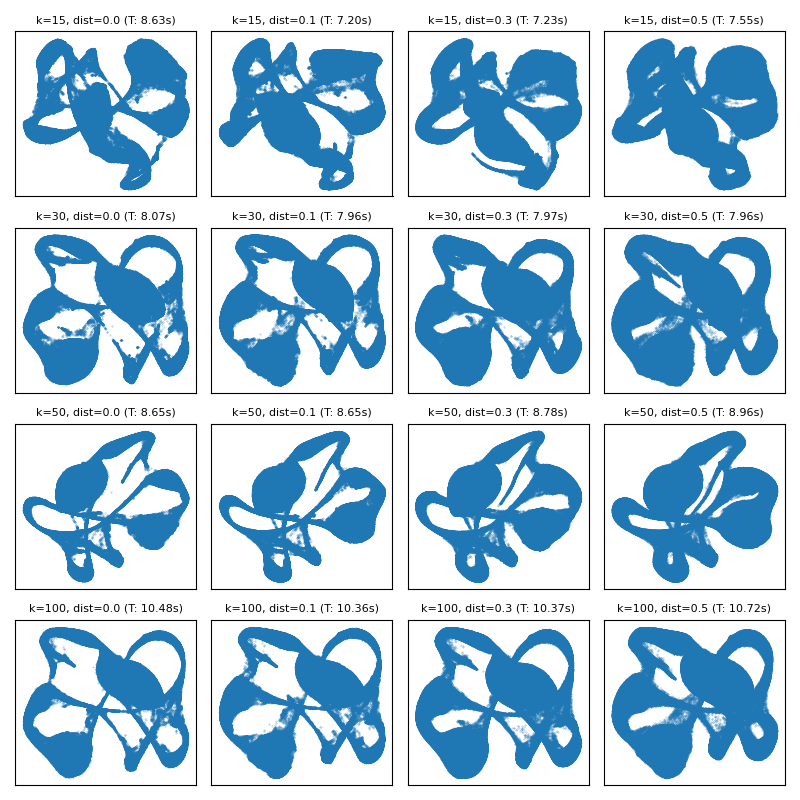

In [3]:
# Path to file with features
FEATURES_DF_PATH = 'sq_rect_tracks_5f_features.jsonl'
METADATA_PATH = '/home/nbahou/myimaging/scDINO/scDINO/sim_tracks_sq_rect_2way_5f_d5_meta/metadata.csv'

# Use these parameters if the dataset was generated with our preprocessing pipeline
RUN_NAME = None
EXP_NAME = None
BASE_DIR = None


# Initialize Processor (loads features_df)
processor = DataProcessor(FEATURES_DF_PATH)


# Generate phenotype column from annotations in metadata path
df_final = processor.apply_phenotype(METADATA_PATH)


# B. Find best parameters with Grid Search
param_grid = {
    'n_neighbors': [15, 30, 50, 100],
    'min_dist': [0.0, 0.1, 0.3, 0.5]
}

print("\n--- Starting UMAP Grid Search ---")

results_df, embeddings = run_umap_grid_search(
    processor=processor, 
    param_grid=param_grid, 
    visualization=True
)

In [4]:
# Legacy Code (works better with synth_data)
import umap

NUM_UMAP_COMPONENTS = 2
RANDOM_STATE = 42

X_embeddings = np.array(df_final['embedding'].tolist())

reducer = umap.UMAP(
    n_components=NUM_UMAP_COMPONENTS,  # Uses the configured number of dimensions
    random_state=RANDOM_STATE,
    n_neighbors=15,
    min_dist=0.1,
    verbose=False # Set to True if you want progress output
)

# Perform the reduction
umap_coordinates = reducer.fit_transform(X_embeddings)

df_final['umap_1'] = umap_coordinates[:, 0]
df_final['umap_2'] = umap_coordinates[:, 1]

/home/nbahou/miniforge3/envs/umap_explorer/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
# Select final UMAP params from gridsearch
FINAL_N_NEIGHBORS = 100
FINAL_MIN_DIST = 0.0

# C. Compute the Final Embedding
final_embedding = processor.compute_embedding(
    topometry=False, 
    n_neighbors=FINAL_N_NEIGHBORS, 
    min_dist=FINAL_MIN_DIST
)

# D. Attach UMAP Coordinates back to the DataFrame
df_final['umap_1'] = final_embedding[:, 0]
df_final['umap_2'] = final_embedding[:, 1]

[2026-01-29 16:20:20.252] [CUML] [info] build_algo set to brute_force_knn because random_state is given
Computed UMAP embedding of shape: (450000, 2)


## Interactive Explorer

### Class Definition

In [5]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout, VBox, HBox, Button, IntSlider, FloatSlider, SelectMultiple, Checkbox, Dropdown, Text, HTML, Output
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import NearestNeighbors # Assuming this import is needed for neighbor search
import plotly.express as px
from matplotlib import colors as mcolors
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class BioExplorer:

    def __init__(self, df: pd.DataFrame):
        
        # === 1. STATE (MODEL) ===
        self.df = df.copy()

        if 'filename' not in self.df.columns:
            self.df['filename'] = 'unknown_experiment'

        # Save original track_id (per-file) before overwriting
        if 'original_track_id' not in self.df.columns:
            if 'track_id' in self.df.columns:
                self.df = self.df.rename(columns={'track_id': 'original_track_id'})
            else:
                self.df['original_track_id'] = range(len(self.df))

        # Create truly unique global track_id: (filename, original_track_id) → integer
        self.df['track_id'] = self.df.groupby(['filename', 'original_track_id']).ngroup()

        # Update all_track_ids to use the new global IDs
        # TODO: variable assigned two times, see below. Remove one
        self.all_track_ids = sorted(self.df['track_id'].unique())

        # Ensure label_manual exists and has correct type
        if 'label_manual' not in self.df.columns:
            self.df['label_manual'] = 'unlabeled'
        else:
            # Force to object dtype so strings work
            self.df['label_manual'] = self.df['label_manual'].astype('object')
        
        # Initialize internal state based on input data
        self.all_track_ids = self.df['track_id'].unique().tolist() # Derived internally (as discussed)
        self.df_filtered = self.df.copy() # The data currently being plotted (affected by phenotype filter)
        
        self.feats = np.array(self.df['embedding'].tolist())

        try:
            from cuml import UMAP as GPUUMAP
            self.UMAP_Class = GPUUMAP
        except:
            import umap
            self.UMAP_Class = umap.UMAP

        # === ML CLASSIFIER ===
        self.classifier = None           # Will hold the trained sklearn model
        self.label_encoder = None        # For phenotype string ↔ int mapping
        self.predicted_phenotype_col = 'phenotype_predicted'  # Name of prediction column
        # TODO: We first do without this, might keep for later.
        self.train_track_ids = None  # New: Store train track IDs
        self.val_track_ids = None  # New: Store val track IDs
        
        # Train the initial classifier on original phenotypes
        # TODO: Unsure whether auto training here makes sense
        self._train_classifier()
        
            
        # Dynamic State Variables (Default values for widgets)
        self.selected_tracks = []
        self.k_neighbors = 5
        self.point_opacity = 0.7
        self.current_annotation_text = "new_label"
        self.nbrs = None # NearestNeighbors model container
        self.current_highlighted_neighbor = None
        

        # === 2. PLOT INITIALIZATION (VIEW) ===
        self.fig = go.FigureWidget()
        self.fig.update_layout(
            dragmode='zoom', 
            height=700, 
            width=900,
            title="scDINO UMAP - Interactive Explorer"
        )
        with self.fig.batch_update():
            self.fig.add_trace(go.Scattergl(
                x=[], y=[], mode='markers', name='Points'
            ))
            # Now attach the click handler
            self.fig.data[0].on_click(self.on_click_point)
        
        # === 3. WIDGETS & CALLBACKS (CONTROLLER) ===
        self._create_widgets()
        self._attach_callbacks()
        
        # === 4. INITIAL SETUP & DRAW ===
        self._update_neighbors_model() # Build the initial KNN model
        self.update_plot()            # Initial draw of the plot
        self._build_layout()
        display(self.ui)              # Display the final UI container


    # ----------------------------------------
    # ⚙️ WIDGET & LAYOUT METHODS (Controller)
    # ----------------------------------------

    def _create_widgets(self):
        """Define all ipywidgets and assign them to self."""
        # --- Filters ---
        self.phenotype_filter = SelectMultiple(
            options=sorted(self.df['phenotype'].unique()), 
            value=[], 
            description='Phenotypes:', 
            layout=Layout(width='200px', height='100px')
        )
        
        # --- Track Management ---
        # Note: track_id_dropdown options must be set dynamically after init
        self.track_id_dropdown = Dropdown(
            options=sorted(self.all_track_ids, key=lambda x: int(x) if str(x).isdigit() else x),
            description='Add Track:'
        )
        self.track_input = Text(
            value='',
            placeholder='e.g., 1,5,12',
            description='Track IDs:',
            layout=Layout(width='200px')
        )
        self.trajectory_color_mode = Dropdown(
            options=['Track', 'Time', 'Phenotype', 'Apo Status'],
            value='Track',
            description='Color by:',
            layout=Layout(width='180px')
        )
        self.track_add_button = Button(description='Add', button_style='success')
        self.track_clear_button = Button(description='Clear', button_style='danger')
        self.track_list_display = HTML(value="Selected: None")
        self.track_connect_checkbox = Checkbox(description='Show trajectories')
        self.track_filter_checkbox = Checkbox(
            value=False,
            description='Show only selected tracks',
            indent=False
        )
        
        
        # --- Visuals & Settings ---
        self.point_opacity_slider = FloatSlider(value=self.point_opacity, min=0.05, max=1.0, step=0.05, description='Opacity:')
        self.point_size_slider = IntSlider(
            value=6, min=1, max=20, step=1, 
            description='Point size:',
            continuous_update=False
        )
        self.show_density_checkbox = Checkbox(value=False, description='Show density contours')
        self.density_per_phenotype = Checkbox(
            value=False,
            description='Per-phenotype density',
        )
        self.k_slider = IntSlider(value=self.k_neighbors, min=1, max=20, step=1, description='Neighbors (k):', continuous_update=False)
        self.coords_display = Text(value='', placeholder='Click on a point', disabled=True, description='Coords:')

        # --- Annotation & ML ---
        self.annotation_mode_checkbox = Checkbox(description='Annotation mode')
        self.annotation_text_input = Text(value=self.current_annotation_text, placeholder='Label text...')
        self.color_by_dropdown = Dropdown(
            options=[
                ('Original phenotype', 'phenotype'),
                ('Manual labels', 'label_manual'),
                ('Predicted phenotype', 'phenotype_predicted'),  # ← new!
            ],
            value='phenotype',
            description='Color by:'
        )
        self.clear_annotations_button = Button(description='Clear Labels', button_style='warning')
        self.output_neighbors = Output()
        self.output_selection_stats = Output()

        self.dragmode_dropdown = Dropdown(
            options=['zoom', 'pan', 'select', 'lasso'],
            value='zoom', # Start with zoom/pan for exploration
            description='Drag Mode:',
            layout=Layout(width='150px')
        )

        # --- UMAP Recompute Panel ---
        self.umap_n_neighbors = IntSlider(value=50, min=5, max=200, step=5, description='n_neighbors:', continuous_update=False)
        self.umap_min_dist = FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='min_dist:', continuous_update=False)
        self.umap_topometry = Checkbox(value=False, description='Use TopOMetry')
        self.umap_recompute_btn = Button(description='Recompute UMAP', button_style='info', icon='refresh')


        # --- ML Panel ---
        self.label_source_dropdown = Dropdown(
            options=[
                ('Original phenotype', 'phenotype'),
                ('Manual annotations', 'label_manual')
            ],
            value='phenotype',
            description='Train on:',
            layout=Layout(width='220px')
        )

        self.retrain_button = Button(
            description='Retrain Classifier',
            button_style='primary',
            icon='brain',
            layout=Layout(width='180px')
        )
        self.classifier_report_button = Button(
            description="Classifier Report", 
            button_style='info', 
            icon='chart-bar'
        )


    def _attach_callbacks(self):
        """Link all widgets to their respective handler methods."""
        
        # State/Model change handlers (re-calculate KNN model)
        self.k_slider.observe(self._on_k_change, names='value')
        self.phenotype_filter.observe(self._on_phenotype_filter_change, names='value')
        
        # Visual change handlers (re-draw plot)
        self.point_opacity_slider.observe(self._on_opacity_change, names='value')
        self.point_size_slider.observe(self._on_point_size_change, names='value')
        self.color_by_dropdown.observe(self.update_plot, names='value')
        self.show_density_checkbox.observe(self.update_plot, names='value')
        self.density_per_phenotype.observe(self.update_plot, names='value')
        self.track_connect_checkbox.observe(self.update_plot, names='value')
        self.track_filter_checkbox.observe(self.update_plot, names='value')
        self.trajectory_color_mode.observe(self.update_plot, names='value')
        self.dragmode_dropdown.observe(self._on_dragmode_change, names='value')
        self.umap_recompute_btn.on_click(self._on_recompute_umap)

        self.track_input.continuous_update = False
        self.track_input.observe(self._on_track_input_change, names='value')
        
        # Button handlers
        self.track_add_button.on_click(self._on_track_add_button)
        self.track_clear_button.on_click(self._on_track_clear_button)
        self.clear_annotations_button.on_click(self._on_clear_annotations)
        
        self.classifier_report_button.on_click(self._show_classifier_report)
        self.retrain_button.on_click(self._on_retrain_classifier)
        self.classifier_report_button.on_click(self._show_classifier_report)


    def _build_layout(self):
        """Assemble all widgets into the final VBox/HBox structure."""
        
        top_row = HBox([self.coords_display, self.k_slider, self.dragmode_dropdown])
        
        track_panel = VBox([
            HTML(value="<b>🛤️ Track Selection:</b>"),
            HBox([self.track_id_dropdown, self.track_add_button, self.track_input, self.track_clear_button]),
            self.track_list_display,
            HBox([self.track_filter_checkbox, self.track_connect_checkbox]),
            HBox([HTML(value="<b>Trajectory coloring:</b>", layout=Layout(width='120px')),
                  self.trajectory_color_mode])
        ], layout=Layout(border='1px solid #ddd', padding='10px', margin='5px'))

        controls_panel = HBox([
            VBox([HTML(value="<b>🔬 Filters:</b>"), self.phenotype_filter]),
            VBox([HTML(value="<b>🎨 Visuals:</b>"), 
                  self.point_opacity_slider,
                  self.point_size_slider,
                  self.show_density_checkbox,
                  self.density_per_phenotype,]),
            VBox([
                HTML(value="<b>📝 Annotation/Color:</b>"), 
                self.annotation_mode_checkbox, 
                self.annotation_text_input, 
                self.color_by_dropdown, 
                self.clear_annotations_button
            ]),
        ], layout=Layout(spacing='20px'))

        umap_panel = VBox([
            HTML("<b>UMAP Parameters</b>"),
            HBox([self.umap_n_neighbors, self.umap_min_dist]),
            HBox([self.umap_topometry, self.umap_recompute_btn]),
        ], layout=Layout(border='1px solid #ccc', padding='10px', margin='10px 0', background_color='#f8f8f8'))

        ml_panel = VBox([
            HTML("<b>Machine Learning Panel</b>"),
            self.label_source_dropdown,
            HBox([self.retrain_button, self.classifier_report_button]),
        ], layout=Layout(
            border='1px solid #ccc',
            padding='12px',
            margin='10px 0',
            background_color='#f0f8ff'
        ))

        outputs_row = HBox([
            VBox([HTML(value="<b>👥 Neighbors:</b>"), self.output_neighbors]), 
            VBox([HTML(value="<b>📊 Stats:</b>"), self.output_selection_stats])
        ])

        self.ui = VBox([
            top_row, 
            track_panel, 
            controls_panel, 
            umap_panel,
            ml_panel,
            self.fig, 
            outputs_row
        ])


    # ----------------------------------------
    # 🏃 CORE LOGIC METHODS (Model/View Update)
    # ----------------------------------------

    def _update_neighbors_model(self):
        """Re-fit the NearestNeighbors model based on filtered data."""
        if len(self.df_filtered) > self.k_neighbors:
            # We assume UMAP coords are 'umap_1' and 'umap_2'
            X = self.df_filtered[['umap_1', 'umap_2']].values
            self.nbrs = NearestNeighbors(n_neighbors=self.k_neighbors, algorithm='auto').fit(X)
        else:
            self.nbrs = None
            self.output_neighbors.clear_output(wait=True)
            with self.output_neighbors:
                print("Not enough points to fit KNN model.")

    def _get_or_create_color_mapping(self, series: pd.Series) -> tuple:
        series = series.fillna('unlabeled').astype(str)
    
        # Create persistent mapping on the object if it doesn't exist yet
        if not hasattr(self, "_label_color_map"):
            self._label_color_map = {}
    
        # Fixed gray for unlabeled
        self._label_color_map.setdefault('unlabeled', '#AAAAAA')
    
        # The palette you want to cycle through
        palette = px.colors.qualitative.Plotly + px.colors.qualitative.Safe
        palette_len = len(palette)
    
        # Assign colors to any *new* labels
        for label in series:
            if label not in self._label_color_map:
                # Next color in sequence
                idx = len(self._label_color_map) - 1  # -1 because 'unlabeled' occupies index 0
                self._label_color_map[label] = palette[idx % palette_len]
    
        # Convert column to color values
        color_values = series.map(self._label_color_map).values
    
        # Return values + the mapping + unique labels
        return color_values, self._label_color_map, sorted(self._label_color_map.keys())



    def update_plot(self, _=None):
        data = self.df.copy()

        # Apply phenotype filter if active
        if self.phenotype_filter.value:
            data = data[data['phenotype'].isin(self.phenotype_filter.value)]

        # Apply track filter if checkbox is ON and tracks are selected
        if self.track_filter_checkbox.value and self.selected_tracks:
            data = data[data['track_id'].isin(self.selected_tracks)]

        # Update filtered view + KNN model
        self.df_filtered = data
        self._update_neighbors_model()

        # === NOW PLOT USING self.df_filtered ===
        color_col = self.color_by_dropdown.value
        scatter_data = self.df_filtered
    
        with self.fig.batch_update():
            self.fig.data = []
    
    
            # --- Main Scatter ---
            if not scatter_data.empty:
                color_values, color_map, unique_labels = self._get_or_create_color_mapping(
                    scatter_data[color_col]
                )
    
                scatter_trace = go.Scattergl(
                    x=scatter_data['umap_1'],
                    y=scatter_data['umap_2'],
                    mode='markers',
                    name='Points',
                    showlegend=False,
                    marker=dict(
                        size=self.point_size_slider.value,
                        opacity=self.point_opacity_slider.value,
                        color=color_values,
                    ),
                    customdata=np.column_stack((
                        scatter_data['track_id'],           # global ID
                        scatter_data['original_track_id'],  # per-file ID
                        scatter_data['filename'],
                        scatter_data['t'] if 't' in scatter_data.columns else np.full(len(scatter_data), ''),
                        scatter_data[color_col]
                    )),
                    hovertemplate=(
                        "<b>Global Track ID:</b> %{customdata[0]}<br>"
                        "<b>Original Track ID:</b> %{customdata[1]}<br>"
                        "<b>File:</b> %{customdata[2]}<br>"
                        "<b>UMAP:</b> (%{x:.3f}, %{y:.3f})<br>"
                        + ("<b>Time:</b> %{customdata[3]}<br>" if 't' in scatter_data.columns else "")
                        + f"<b>{color_col}:</b> %{{customdata[4]}}<extra></extra>"
                    ),
                    text=scatter_data['track_id'].astype(str) +
                         (" / t=" + scatter_data['t'].astype(str) if 't' in scatter_data.columns else ""),
                )
                self.fig.add_trace(scatter_trace)
                
    
                # Optional: add legend traces so user sees the mapping
                if color_col == "phenotype":
                    legend_labels = sorted(
                        set(self.df['phenotype'].dropna().astype(str))
                    )
                elif color_col == "label_manual":
                    legend_labels = sorted(
                        set(self.df['label_manual'].dropna().astype(str))
                    )
                else:
                    legend_labels = []

                legend_labels = [l for l in legend_labels if l != "unlabeled"]

                for label in legend_labels:
                    self.fig.add_trace(go.Scattergl(
                        x=[None], y=[None],
                        mode="markers",
                        marker=dict(size=10, color=color_map[label]),
                        name=label,
                        showlegend=True
                    ))

            # --- Density Contours ---
            if self.show_density_checkbox.value and not scatter_data.empty:
                x_min, x_max = scatter_data['umap_1'].min(), scatter_data['umap_1'].max()
                y_min, y_max = scatter_data['umap_2'].min(), scatter_data['umap_2'].max()
                x_range = [x_min - 0.5, x_max + 0.5]
                y_range = [y_min - 0.5, y_max + 0.5]

                if self.density_per_phenotype.value:
                    # Use phenotype colors consistently
                    _, pheno_color_map, _ = self._get_or_create_color_mapping(scatter_data['phenotype'])
                    self._add_per_phenotype_density(scatter_data, pheno_color_map, x_range, y_range)
                else:
                    self._add_global_density_contour(scatter_data, x_range, y_range)
    
            # --- Trajectories ---
            self._add_selected_tracks_overlay()
    
        # Re-attach click handler
        if self.fig.data and self.fig.data[0].name == 'Points':
            self.fig.data[0].on_click(self.on_click_point)
            self.fig.data[0].on_selection(self.on_lasso_select)

        self._update_track_list_display()

    def _hex_to_rgb(self, hex_color): 
        """Converts a hex color string (e.g., '#1f77b4') to an (R, G, B) tuple."""
        try:
            # mcolors.to_rgb returns (r, g, b) as floats between 0 and 1
            rgb_float = mcolors.to_rgb(hex_color)
            # Convert to 0-255 integers
            return tuple(int(c * 255) for c in rgb_float) # CONVERT TO TUPLE
        except ValueError:
            return 0, 0, 0 # Fallback to black if conversion fails

    def _add_global_density_contour(self, data, x_range, y_range):
        """Calculates global density."""
        if len(data) < 100:
            return

        x = data['umap_1'].values
        y = data['umap_2'].values

        # Use same range and ~100 bins → crisp + fast
        H, xedges, yedges = np.histogram2d(
            x, y, bins=100, range=[x_range, y_range], density=True
        )
        H = gaussian_filter(H, sigma=1.5)
        H = np.ma.masked_where(H < H.max() * 0.1, H)  # soft threshold

        xcenters = (xedges[:-1] + xedges[1:]) / 2
        ycenters = (yedges[:-1] + yedges[1:]) / 2

        self.fig.add_trace(go.Contour(
            x=xcenters,
            y=ycenters,
            z=H.T,
            colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'black']],
            line=dict(width=2, color='black'),
            contours=dict(
                coloring='lines',
                showlabels=False,
                start=0,
                end=H.max(),
                size=H.max() / 10
            ),
            opacity=0.7,
            showscale=False,
            name='Global density',
            hoverinfo='skip'
        ))

    def _add_per_phenotype_density(self, data, color_map, x_range, y_range):
        """Generates per-phenotype contours."""
        if len(data) < 100:
            return
    
        # Find the maximum density across all phenotypes for normalization consistency
        # This step is optional but can make color comparison between phenos more meaningful
        H_combined = []
        for pheno in color_map.keys():
            sub = data[data['phenotype'] == pheno]
            if len(sub) < 30: continue
            x = sub['umap_1'].values
            y = sub['umap_2'].values
            H_sub, _, _ = np.histogram2d(x, y, bins=80, range=[x_range, y_range], density=True)
            H_sub = gaussian_filter(H_sub, sigma=2.0)
            H_combined.append(H_sub)
        
        if not H_combined: return
    
        # Use the max density from the most concentrated phenotype for normalization
        H_max_global = np.max([H.max() for H in H_combined])
        if H_max_global == 0: return
    
        for pheno, color in color_map.items():
            sub = data[data['phenotype'] == pheno]
            if len(sub) < 30:
                continue
    
            x = sub['umap_1'].values
            y = sub['umap_2'].values
    
            H, xedges, yedges = np.histogram2d(
                x, y, bins=80, range=[x_range, y_range], density=True
            )
            H = gaussian_filter(H, sigma=2.0)
            
            # --- SOLUTION STEP 1: Normalize H by the overall maximum ---
            # This scales the density values to the 0-1 range based on the highest peak.
            H_normalized = H / H_max_global
            
            # Apply mask to the normalized array (mask values below 0.3 of the *local* max)
            H_masked = np.ma.masked_where(H < H.max() * 0.05, H)
            
            # Normalize the masked array (or just H, then mask by H_max_global)
            # Let's stick to normalizing H, then masking the normalized array based on the 0.3 threshold
            H_normalized = H / H_max_global
            mask_threshold = (H.max() * 0.05) / H_max_global # Calculate the threshold in the 0-1 range
            H_masked_normalized = np.ma.masked_where(H_normalized < mask_threshold, H_normalized)
    
    
            # --- Extract RGB and create custom colorscale ---
            R, G, B = self._hex_to_rgb(color) # Use the helper function!
            min_alpha = 0.3
            
            color_start_str = f'rgba({R},{G},{B}, {min_alpha})' 
    
            colorscale_with_min_alpha = [
                [0.0, 'rgba(0,0,0,0)'], # Fully transparent for masked data (density=0)
                [0.0001, color_start_str], # Start the color (with 0.5 alpha) just above zero
                [1.0, color] # Full opacity at max density
            ]
    
            xcenters = (xedges[:-1] + xedges[1:]) / 2
            ycenters = (yedges[:-1] + yedges[1:]) / 2
    
            self.fig.add_trace(go.Contour(
                x=xcenters,
                y=ycenters,
                z=H_masked_normalized.T, # Use the normalized and masked Z data
                colorscale=colorscale_with_min_alpha, # Use the new colorscale
                line=dict(color=color, width=2.5),
                contours=dict(coloring='lines', showlabels=False),
                opacity=1.0, # Reset global opacity to 1.0 (controlled by colorscale)
                showscale=False,
                name=f'{pheno} density',
                hoverinfo='skip'
            ))


    def _add_selected_tracks_overlay(self):
        """Draw highlighted points + trajectories using the selected coloring mode."""
        if not self.selected_tracks:
            return

        mode = self.trajectory_color_mode.value

        pheno_vals, pheno_map, _ = self._get_or_create_color_mapping(self.df['phenotype'])

        for track_id in self.selected_tracks:
            track_data = self.df_filtered[self.df_filtered['track_id'] == track_id]
            if len(track_data) == 0:
                continue
            track_data = track_data.sort_values('t')

            # ——— Determine color based on mode ———
            if mode == 'Track':
                color = px.colors.qualitative.Plotly[self.selected_tracks.index(track_id) % 10]
                marker_colors = color
                line_color = color
            elif mode == 'Time':
                # Continuous color by time (viridis)
                t_norm = (track_data['t'] - track_data['t'].min()) / (track_data['t'].max() - track_data['t'].min() + 1e-8)
                marker_colors = px.colors.sample_colorscale('viridis', t_norm.tolist())
                line_color = 'gray'
            elif mode == 'Phenotype':
                marker_colors = [pheno_map.get(str(p), 'gray') for p in track_data['phenotype']]
                line_color = 'gray'
            elif mode == 'Apo Status':
                label = track_data['label_manual'].iloc[0]
                has_apo = pd.notna(label) and 'apo' in str(label).lower()
                color = 'red' if has_apo else 'cyan'
                marker_colors = color
                line_color = color


            # ——— Highlight points (always visible) ———
            self.fig.add_trace(go.Scattergl(
                x=track_data['umap_1'],
                y=track_data['umap_2'],
                mode='markers',
                marker=dict(size=7, color=marker_colors, line=dict(width=2, color='white')),
                showlegend=False,
                hoverinfo='none'
            ))

            # ——— Draw trajectory if enabled ———
            if self.track_connect_checkbox.value and len(track_data) >= 2:
                self.fig.add_trace(go.Scattergl(
                    x=track_data['umap_1'],
                    y=track_data['umap_2'],
                    mode='lines+markers',
                    line=dict(color=line_color, width=1.8),
                    marker=dict(size=7, color=marker_colors, line=dict(width=1.2, color='white')),
                    name=f"Track {track_id}",
                    text=track_data['t'].astype(str),
                    hovertemplate=f"<b>Track {track_id}</b><br>t=%{{text}}<extra></extra>"
                ))


    # ----------------------------------------
    # 🖱️ CALLBACK HANDLERS (Controller)
    # ----------------------------------------
    
    def _on_k_change(self, change):
        """Updates k and refits KNN model."""
        self.k_neighbors = change.new
        self._update_neighbors_model()

    def _on_opacity_change(self, change):
        """Optimized update for marker opacity."""
        self.point_opacity = change.new
        if self.fig.data and self.fig.data[0].name == 'Points':
             self.fig.data[0].marker.opacity = self.point_opacity

    def _on_point_size_change(self, change):
        """Update only the marker size of the main scatter (fast, no full redraw)."""
        new_size = change.new
        if self.fig.data and len(self.fig.data) > 0 and self.fig.data[0].name == 'Points':
            with self.fig.batch_update():
                self.fig.data[0].marker.size = new_size
        # Also update selected track points to keep visual harmony
        for trace in self.fig.data:
            if trace.mode in ['markers', 'lines+markers'] and trace.name != 'Points':
                with self.fig.batch_update():
                    trace.marker.size = max(8, new_size + 2)  # selected tracks a bit larger
    
    def _on_phenotype_filter_change(self, change):
        self.update_plot()

    def _on_track_add_button(self, b):
        track_id = self.track_id_dropdown.value
        if track_id is not None and track_id not in self.selected_tracks:
            self.selected_tracks.append(track_id)
            self.update_plot()  # Might be sufficient to just call _add_selected_tracks_overlay here
            self._update_track_list_display()
        
    def _on_track_clear_button(self, b):
        """Clears all selected tracks."""
        self.selected_tracks = []
        self.update_plot()

    def _on_track_input_change(self, change):
        text = change.new.strip()
        if not text:
            return

        try:
            candidate_ids = [int(x) for x in text.split(',') if x.strip().isdigit()]
        except:
            self.track_list_display.value = "<span style='color:red'>Invalid input</span>"
            return

        # Convert all_track_ids to set of int for O(1) lookup
        track_id_set = set(map(int, self.all_track_ids))  # ← forces Python int

        valid_ids = [tid for tid in candidate_ids if tid in track_id_set]

        if not valid_ids:
            self.track_list_display.value = "<span style='color:orange'>No valid track IDs found</span>"
            return

        new_tracks = [tid for tid in valid_ids if tid not in self.selected_tracks]
        self.selected_tracks.extend(new_tracks)

        self.update_plot()
        self.track_input.value = ''  # clear box
        self._update_track_list_display()

    def _on_clear_annotations(self, b):
        """Clears manual labels."""
        self.df['label_manual'] = 'unlabeled'
        self.df['label_manual'] = self.df['label_manual'].astype('object')  # keep dtype
        if 'label_manual' in self.df_filtered.columns:
            self.df_filtered['label_manual'] = 'unlabeled'
        self.update_plot()

    def _on_recompute_umap(self, btn):
        btn.disabled = True
        btn.description = "Computing..."
        
        try:
            # Get current params
            n_neighbors = self.umap_n_neighbors.value
            min_dist = self.umap_min_dist.value
            topometry = self.umap_topometry.value
            
            print(f"Computing new UMAP (n_neighbors={n_neighbors}, min_dist={min_dist}, topometry={topometry})...")
            
            # Run your existing function
            embedding = self.compute_embedding(
                topometry=topometry,
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                random_state=42
            )
            
            # Update coordinates in BOTH dataframes
            self.df[['umap_1', 'umap_2']] = embedding
            self.df_filtered[['umap_1', 'umap_2']] = embedding[self.df.index.isin(self.df_filtered.index)]
            
            # Rebuild KNN model with new geometry
            self._update_neighbors_model()
            
            # Redraw everything
            self.update_plot()
            
            print("New UMAP computed and applied!")
            
        except Exception as e:
            print(f"Error during UMAP computation: {e}")
        finally:
            btn.disabled = False
            btn.description = "Recompute UMAP"

    def _update_track_list_display(self):
        if self.selected_tracks:
            info = []
            for gid in self.selected_tracks:
                row = self.df[self.df['track_id'] == gid].iloc[0]
                orig = row['original_track_id']
                file = row['filename'].split('/')[-1]  # just basename
                info.append(f"{gid} (orig {orig}, {file})")
            self.track_list_display.value = f"<b>Selected:</b> {', '.join(info)}"
        else:
            self.track_list_display.value = "Selected: None"

    def _on_dragmode_change(self, change):
        """Update Plotly's dragmode based on the widget selection."""
        new_mode = change.new
        with self.fig.batch_update():
            self.fig.layout.dragmode = new_mode

    def _on_retrain_classifier(self, btn):
        btn.disabled = True
        btn.description = "Training..."
        try:
            self._train_classifier()
        finally:
            btn.disabled = False
            btn.description = "Retrain Classifier"


    # ----------------------------------------
    # INTERACTIVE ML/ANNOTATION LOGIC
    # ----------------------------------------

    def on_click_point(self, trace, points, state):
        """
        Entry point for click events on the main scatter plot.
        """
        if not points.point_inds: return
        
        # 1. Get the visual index of the clicked point (e.g., the 50th dot drawn)
        clicked_idx_in_trace = points.point_inds[0]

        # 2. Retrieve the Pandas Index from the filtered dataframe using the visual index
        try:
            original_idx = self.df_filtered.index[clicked_idx_in_trace]
        except IndexError:
            # Safety catch in case plot/data sync issues occur
            return
        
        row_in_original = self.df.loc[original_idx]
        
        # Display Coordinates
        self.coords_display.value = f"({row_in_original['umap_1']:.2f}, {row_in_original['umap_2']:.2f})"
        
        self._show_neighbors(original_idx)

    def on_lasso_select(self, trace, points, selector):
        """Handle lasso/box selection — label in annotation mode."""
        if not points.point_inds:
            return
        
        # Get original indices from filtered data
        sel_idx = [self.df_filtered.index[i] for i in points.point_inds]

    
        
        if self.annotation_mode_checkbox.value:
            label = self.annotation_text_input.value or "new_label"
            self.df.loc[sel_idx, 'label_manual'] = label
            self.df_filtered.loc[sel_idx, 'label_manual'] = label
            self.update_plot()
            self.output_selection_stats.clear_output(wait=True)
            with self.output_selection_stats:
                print(f"Labeled {len(sel_idx)} points as '{label}'")
        else:
            # Optional: show stats
            selected = self.df_filtered.iloc[points.point_inds]
            self.output_selection_stats.clear_output(wait=True)
            with self.output_selection_stats:
                print(f"Selected {len(selected)} points")
                print(selected['phenotype'].value_counts())

    # TODO: Continue here
    def _show_neighbors(self, original_idx):
        """Logic to calculate and display nearest neighbors and track stats."""
        self.output_neighbors.clear_output(wait=True)
        self.output_selection_stats.clear_output(wait=True)

        if self.nbrs is None or len(self.df_filtered) < self.k_neighbors:
            with self.output_neighbors:
                print("KNN Model not available or data is too small.")
            return

        # 1. Find the index of the clicked point in the *filtered* data
        point_idx_in_filtered = self.df_filtered.index.get_loc(original_idx)
        X_filtered = self.df_filtered[['umap_1', 'umap_2']].values
        
        # 2. Query the NearestNeighbors model
        distances, indices = self.nbrs.kneighbors(X_filtered[point_idx_in_filtered].reshape(1, -1))
        
        # 3. Get the actual data points (neighbors)
        neighbor_indices_in_filtered = indices.flatten() # Exclude the point itself
        neighbor_data = self.df_filtered.iloc[neighbor_indices_in_filtered]
        neighbor_data['distance'] = distances.flatten()
        
        # 4. Display Neighbors
        with self.output_neighbors:
            print(f"Nearest {self.k_neighbors-1} Neighbors:")
            print(neighbor_data[['track_id', 't', 'phenotype', 'label_manual', 'distance']])

        self.show_neighbor_images(neighbor_data)

        # 5. Display Stats (Example: Phenotype distribution of neighbors)
        with self.output_selection_stats:
            print("Neighbor Phenotype Distribution:")
            print(neighbor_data['phenotype'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

    def show_neighbor_images(self, neighbors_df):
        """Display multi-channel image grid for nearest neighbors with click interactivity."""
        k = len(neighbors_df)
        if k == 0:
            with self.output_neighbors:
                print("No neighbors to display.")
            return
    
        # Clear any previous output
        self.output_neighbors.clear_output(wait=True)
    
        # Auto-detect number of channels
        n_channels = 5  # fallback
        for _, row in neighbors_df.iterrows():
            path = row.get('path') or row.get('frame_path')
            if pd.notna(path) and os.path.exists(path):
                try:
                    test_img = tifffile.imread(path)
                    if test_img.ndim == 3:
                        if test_img.shape[0] <= 32:  # likely C,H,W
                            n_channels = test_img.shape[0]
                        else:
                            n_channels = test_img.shape[-1]  # H,W,C
                    elif test_img.ndim == 2:
                        n_channels = 1
                    break
                except:
                    continue
    
        # Everything inside the output widget context
        with self.output_neighbors:
            fig, axes = plt.subplots(k, n_channels,
                                     figsize=(1.2 * n_channels, 1.0 * k),
                                     constrained_layout=True)
    
            # Handle single row/col cases
            if k == 1:
                axes = axes.reshape(1, -1)
            if n_channels == 1:
                axes = axes.reshape(-1, 1)
    
            # Store row highlights for toggling
            row_highlights = []
            neighbor_indices = []  # Store original dataframe indices
    
            # Fill the grid
            for i, (idx, row) in enumerate(neighbors_df.iterrows()):
                neighbor_indices.append(idx)  # Store the original df index
                path = row.get('path') or row.get('frame_path')
                track_id = row['track_id']
                t = row.get('t', '?')
                # Handle pd.NA safely
                label_manual = row.get('label_manual')
                if not self.annotation_mode_checkbox.value:
                    label = row['phenotype'] if pd.notna(row['phenotype']) else 'unknown'
                else:
                    label = label_manual
                dist = row.get('distance', 0.0)
    
                if not path or not os.path.exists(path):
                    for j in range(n_channels):
                        ax = axes[i, j] if n_channels > 1 else axes[i]
                        ax.imshow(np.zeros((128, 128)), cmap='gray')
                        ax.axis('off')
                    axes[i, 0].text(0.5, 0.5, 'No Image', transform=axes[i, 0].transAxes,
                                    color='red', ha='center', va='center', fontsize=11)
                    row_highlights.append(None)
                    continue
    
                try:
                    img = tifffile.imread(path)
    
                    # Convert (C,H,W) → (H,W,C) if needed
                    if img.ndim == 3 and img.shape[0] <= 32 and img.shape[0] < img.shape[1]:
                        img = img.transpose(1, 2, 0)
    
                    # Ensure 3D
                    if img.ndim == 2:
                        img = img[..., np.newaxis]
    
                    actual_ch = img.shape[-1]
    
                    # Create invisible highlight rectangle for the entire row
                    row_rect = plt.Rectangle(
                        (-0.35, -0.1), n_channels + 0.4, 1.1,
                        transform=axes[i, 0].transAxes,
                        facecolor='yellow', alpha=0.0, zorder=-1,
                        linewidth=3, edgecolor='none'
                    )
                    axes[i, 0].add_patch(row_rect)
                    row_highlights.append(row_rect)
    
                    # Plot each channel
                    for j in range(actual_ch):
                        ax = axes[i, j] if n_channels > 1 else axes[i]
                        ax.imshow(img[..., j], cmap='gray')
                        ax.axis('off')
                        if i == 0:
                            ax.set_title(f"Ch {j+1}", fontsize=10, pad=8)
    
                    # Add info on the left
                    info_ax = axes[i, 0] if n_channels > 1 else axes[i]
                    info_text = f"Track {track_id}\nt={t}\n{label}\nd={dist:.3f}"
                    info_ax.text(-0.28, 0.5, info_text,
                                 transform=info_ax.transAxes,
                                 fontsize=9.5, ha='right', va='center',
                                 bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9))
    
                except Exception as e:
                    for j in range(n_channels):
                        ax = axes[i, j] if n_channels > 1 else axes[i]
                        ax.imshow(np.zeros((128, 128)), cmap='gray')
                        ax.axis('off')
                    axes[i, 0].text(0.5, 0.5, f'Error: {str(e)}', transform=axes[i, 0].transAxes,
                                    color='red', ha='center', va='center', fontsize=9)
                    row_highlights.append(None)
    
            # Add click handler
            def on_click(event):
                """Handle clicks on the neighbor grid."""
                if event.inaxes is None:
                    return
                
                # Find which row was clicked
                clicked_row = None
                for i in range(k):
                    for j in range(n_channels):
                        ax = axes[i, j] if n_channels > 1 else axes[i]
                        if event.inaxes == ax:
                            clicked_row = i
                            break
                    if clicked_row is not None:
                        break
                
                if clicked_row is None:
                    return

                selected_df_idx = neighbor_indices[clicked_row]

                # === NEW: Annotation from neighbor grid when checkbox is ON ===
                if self.annotation_mode_checkbox.value:
                    label = self.annotation_text_input.value.strip()
                    if not label:
                        label = "new_label"
            
                    # Apply label
                    self.df.loc[selected_df_idx, 'label_manual'] = label
                    if selected_df_idx in self.df_filtered.index:
                        self.df_filtered.loc[selected_df_idx, 'label_manual'] = label
            
                    # Visual feedback
                    with self.output_selection_stats:
                        self.output_selection_stats.clear_output(wait=True)
                        print(f"Annotated Track {self.df.loc[selected_df_idx, 'track_id']} → '{label}'")
            
                    # Immediate color update
                    self.update_plot()
                else:
                    # Only print info if not annotating
                    row = self.df.loc[selected_df_idx]
                    with self.output_selection_stats:
                        self.output_selection_stats.clear_output(wait=True)
                        print(f"Clicked neighbor: Track {row['track_id']}, t={row.get('t', '?')}, "
                              f"Phenotype: {row['phenotype']}, Label: {row['label_manual']}")
                
                # Toggle highlights
                for i, rect in enumerate(row_highlights):
                    if rect is not None:
                        if i == clicked_row:
                            # Toggle the clicked row
                            if rect.get_alpha() > 0:
                                rect.set_alpha(0.0)
                                rect.set_edgecolor('none')
                            else:
                                rect.set_alpha(0.2)
                                rect.set_edgecolor('yellow')
                        else:
                            # Dim other rows
                            rect.set_alpha(0.0)
                            rect.set_edgecolor('none')
                
                fig.canvas.draw_idle()
                
                # Highlight in UMAP
                self._highlight_neighbor_in_umap(neighbor_indices[clicked_row])
    
            fig.canvas.mpl_connect('button_press_event', on_click)

            # Keep widget active
            fig.canvas.draw_idle()
            plt.gcf().canvas.draw_idle()
            
            plt.show()

    def _highlight_neighbor_in_umap(self, df_index):
        """Toggle UMAP highlight for the selected neighbor."""
    
        # --- TOGGLE LOGIC ---
        # If this neighbor is currently highlighted -> remove all highlights and stop
        if self.current_highlighted_neighbor == df_index:
            with self.fig.batch_update():
                self.fig.data = tuple(
                    trace for trace in self.fig.data
                    if trace.name != 'Neighbor Highlight'
                )
            self.current_highlighted_neighbor = None  # reset
            
            # Clear text output
            with self.output_selection_stats:
                print("Highlight removed.")
            return
    
        # Otherwise highlight a NEW neighbor
        self.current_highlighted_neighbor = df_index
        row = self.df.loc[df_index]
        x_coord = row['umap_1']
        y_coord = row['umap_2']
        track_id = row['track_id']
    
        # Remove previous highlight traces
        traces_to_keep = [
            trace for trace in self.fig.data
            if trace.name != 'Neighbor Highlight'
        ]
    
        with self.fig.batch_update():
            self.fig.data = tuple(traces_to_keep)
    
            # Add new highlight
            self.fig.add_trace(go.Scattergl(
                x=[x_coord],
                y=[y_coord],
                mode='markers',
                marker=dict(
                    size=16,
                    color='orange',
                    symbol='star-open',
                    line=dict(width=2, color='orange'),
                ),
                name='Neighbor Highlight',
                showlegend=False,
                hovertemplate=f"<b>Selected Neighbor</b><br>Track: {track_id}<br>UMAP: ({x_coord:.3f}, {y_coord:.3f})<extra></extra>"
            ))
    
        # Update info panel
        with self.output_selection_stats:
            self.output_selection_stats.clear_output(wait=True)
            print(f"📍 Highlighted neighbor:")
            print(f"   Track ID: {track_id}")
            print(f"   UMAP: ({x_coord:.3f}, {y_coord:.3f})")
            if 't' in row:
                print(f"   Time: {row['t']}")
            print(f"   Phenotype: {row['phenotype']}")


    def compute_embedding(self, topometry=False, n_neighbors=50, n_components=2, min_dist=0.1, random_state=42) -> np.ndarray:
        """
        Compute 2D embedding using UMAP, optionally enhanced with TopOMetry.
        
        Parameters
        ----------
        feats : np.ndarray or pd.DataFrame
            Feature matrix (cells x features)
        topometry : bool
            Whether to apply TopOMetry graph enhancement first
        n_neighbors : int
            Number of neighbors for UMAP or TopOMetry graph
        n_components : int
            Number of UMAP dimensions
        min_dist : float
            UMAP min_dist parameter
        random_state : int
            Random seed for reproducibility
            
        Returns
        -------
        embedding : np.ndarray
            2D embedding of shape (n_samples, n_components)
        """
        if topometry:
            print("Applying TopOMetry to enhance graph...")
            tg = tp.TopOGraph(
                n_eigs=50,
                base_knn=n_neighbors,
                graph_knn=n_neighbors,
                random_state=random_state,
                n_jobs=-1
            )
            tg.fit(self.feats)
            tg.transform(self.feats)
            
            # Extract the first kernel graph (similarity matrix)
            kernel_obj = list(tg.GraphKernelDict.values())[0]
    
            # Convert to distance: D = 1 - normalized_K
            K = kernel_obj.K.astype(float)
            # normalize to [0,1] if not already
            K = K / K.max()
            
            D = K.copy()                  # copy sparse matrix
            D.data = 1.0 - D.data         # subtract only the non-zero entries
            D.setdiag(0)
            D.eliminate_zeros() # Good practice to clean up
            data_for_umap = D.toarray()
            metric = "precomputed"
            UMAP_Class = self.UMAP_Class # TopOMetry typically forces CPU UMAP
        else:
            data_for_umap = self.feats
            metric = "cosine"
            UMAP_Class = self.UMAP_Class # Use the best available UMAP class
            
        reducer = self.UMAP_Class(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric=metric,
            random_state=random_state
        )
        embedding = reducer.fit_transform(data_for_umap)
        
        return embedding

    def _train_classifier(self):
        """
        Train classifier ONLY on real labeled points.
        Predicts on entire dataset afterward.
        Uses strict track-level split → no leakage.
        """
        from sklearn.linear_model import LogisticRegression
        from sklearn.preprocessing import LabelEncoder
        from sklearn.metrics import accuracy_score, classification_report
    
        # -----------------------------
        # 1. Choose label column
        # -----------------------------
        label_col = 'phenotype'
        if hasattr(self, 'label_source_dropdown') and self.label_source_dropdown is not None:
            label_col = self.label_source_dropdown.value
    
        raw_labels = self.df[label_col].astype(str)
        UNLABELED = {'unknown', 'unlabeled', 'nan', '<NA>', '', 'None', 'NaN'}
        valid_mask = ~raw_labels.isin(UNLABELED) & raw_labels.notna()
        n_labeled = valid_mask.sum()
    
        # Early exit if nothing to train on
        if n_labeled < 10:
            self.classifier = None
            self.label_encoder = None
            self.df[self.predicted_phenotype_col] = 'untrained'
            self._last_classifier_report = {
                'source_column': label_col,
                'n_labeled_used': n_labeled,
                'status': 'failed',
                'reason': 'too_few_labeled_points'
            }
            self._show_classifier_report()  # Still show feedback
            return
    
        # --------------------- Subset to real labeled data ---------------------
        df_labeled = self.df[valid_mask].copy()
        X_labeled = self.feats[valid_mask]
        y_str_labeled = raw_labels[valid_mask]
    
        self.label_encoder = LabelEncoder()
        y_encoded_labeled = self.label_encoder.fit_transform(y_str_labeled)
        real_classes = self.label_encoder.classes_
    
        # --------------------- Track-level stratified split ---------------------
        track_ids = df_labeled['track_id'].values
        temp_df = pd.DataFrame({'track_id': track_ids, 'phenotype': y_str_labeled})
        phen_order = temp_df['phenotype'].value_counts().sort_values().index
    
        track_to_phens = temp_df.groupby('track_id')['phenotype'].apply(set)
        phen_to_tracks = {p: np.array([t for t, s in track_to_phens.items() if p in s]) for p in phen_order}
    
        rng = np.random.default_rng(42)
        train_tracks_set = set()
        val_tracks_set = set()
        split_ratio = 0.8
    
        for p in phen_order:
            tracks = phen_to_tracks[p]
            rng.shuffle(tracks)
            assigned = train_tracks_set | val_tracks_set
            unassigned = [t for t in tracks if t not in assigned]
            if not unassigned:
                continue
            split_idx = int(split_ratio * len(unassigned))
            train_tracks_set.update(unassigned[:split_idx])
            val_tracks_set.update(unassigned[split_idx:])
    
        train_tracks = np.array(sorted(train_tracks_set))
        val_tracks = np.array(sorted(val_tracks_set))
    
        train_mask = np.isin(track_ids, train_tracks)
        val_mask = np.isin(track_ids, val_tracks)
    
        X_train = X_labeled[train_mask]
        X_val = X_labeled[val_mask]
        y_train = y_encoded_labeled[train_mask]
        y_val = y_encoded_labeled[val_mask]
        y_val_str = y_str_labeled[val_mask].values
    
        # --------------------- Train model ---------------------
        self.classifier = LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            max_iter=3000,
            n_jobs=-1,
            class_weight='balanced',
            random_state=42
        )
        self.classifier.fit(X_train, y_train)
    
        # Predict on full dataset
        preds_full = self.classifier.predict(self.feats)
        self.df[self.predicted_phenotype_col] = self.label_encoder.inverse_transform(preds_full)
    
        # --------------------- Balanced validation ---------------------
        n_val_cells = len(y_val_str)
        balanced_accuracy = 0.0
        per_class_metrics = {}
        n_balanced_samples = 0
    
        if n_val_cells > 0:
            val_series = pd.Series(y_val_str)
            min_size = val_series.value_counts().min()
    
            rng2 = np.random.default_rng(123)
            balanced_idx = []
            for cls in val_series.unique():
                idx = np.where(y_val_str == cls)[0]
                keep = rng2.choice(idx, size=min(min_size, len(idx)), replace=False)
                balanced_idx.extend(keep)
            balanced_idx = np.array(balanced_idx)
            n_balanced_samples = len(balanced_idx)
    
            y_val_bal = y_val[balanced_idx]
            y_pred_bal = self.classifier.predict(X_val[balanced_idx])
            y_true_lbl = self.label_encoder.inverse_transform(y_val_bal)
            y_pred_lbl = self.label_encoder.inverse_transform(y_pred_bal)
    
            from sklearn.metrics import accuracy_score, classification_report
            balanced_accuracy = accuracy_score(y_true_lbl, y_pred_lbl)
            report = classification_report(y_true_lbl, y_pred_lbl, output_dict=True)
            per_class_metrics = {
                k: v for k, v in report.items()
                if isinstance(v, dict) and 'f1-score' in v
            }
    
        # --------------------- Store full report ---------------------
        self._last_classifier_report = {
            'source_column': label_col,
            'n_labeled_used': n_labeled,
            'n_train_tracks': len(train_tracks),
            'n_val_tracks': len(val_tracks),
            'n_val_cells': n_val_cells,
            'n_val_balanced': n_balanced_samples,
            'accuracy_balanced': balanced_accuracy,
            'per_class': per_class_metrics,
            'class_order': sorted(real_classes),
            'status': 'success'
        }
    
        # Automatically show the nice report
        if hasattr(self, 'output_selection_stats'):
            self._show_classifier_report()



    def predict_phenotypes(self, feats: np.ndarray) -> np.ndarray:
        """Use the trained classifier to predict phenotypes for new embeddings"""
        if self.classifier is None:
            return np.full(len(feats), 'untrained')
        preds_encoded = self.classifier.predict(feats)
        return self.label_encoder.inverse_transform(preds_encoded)

    def _show_classifier_report(self, btn=None):
        """Centralized report"""
        if not hasattr(self, "_last_classifier_report"):
            with self.output_selection_stats:
                self.output_selection_stats.clear_output(wait=True)
                print("No classifier has been trained yet.")
            return
    
        r = self._last_classifier_report
    
        with self.output_selection_stats:
            self.output_selection_stats.clear_output(wait=True)
    
            if r.get('status') == 'failed':
                print("Classifier training failed")
                print("=" * 50)
                print(f"Reason: {r.get('reason', 'unknown')}")
                print(f"Labeled points: {r.get('n_labeled_used', 0)}")
                return
    
            print("CLASSIFIER REPORT — Track-level split (no leakage)")
            print("=" * 62)
            print(f"Trained on            : {r['source_column']}")
            print(f"Labeled points used   : {r['n_labeled_used']:,}")
            print(f"Train tracks          : {r['n_train_tracks']:,}")
            print(f"Held-out val tracks   : {r['n_val_tracks']:,}")
            print(f"Validation cells      : {r['n_val_cells']:,}")
            print(f"Balanced val samples  : {r['n_val_balanced']:,}")
            print(f"Balanced accuracy     : {r['accuracy_balanced']:.1%}\n")
    
            print("Per-class performance (balanced validation):")
            print("-" * 62)
            if r['per_class']:
                df = pd.DataFrame(r['per_class']).T[['precision', 'recall', 'f1-score', 'support']]
                print(df.round(4))
            else:
                print("   (no validation samples)")
    
            print(f"\nClasses: {', '.join(r['class_order'])}")
            print("\nTraining complete and predictions updated!")


### Run Explorer

In [8]:
df_sample = df_final.sample(n=10000, random_state=42)

In [9]:
print("--- Launching BioExplorer Interactive Dashboard ---")

# The BioExplorer class now only takes the processed DataFrame
#explorer = BioExplorer(df=df_final)
explorer = BioExplorer(df=df_sample)

--- Launching BioExplorer Interactive Dashboard ---


/home/nbahou/miniforge3/envs/umap_explorer/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



## Old stuff but nice for generated UMAPS below

## Config and Data Loading
RUN_NAME should be same used during pre-processing

In [2]:
RUN_NAME = 'Exp06_Site37'
EXP_NAME = 'Exp06_Site37'
BASE_DIR = '/home/nbahou/myimaging/apoDet_refactored'
INPUT_FILE = f"{EXP_NAME}_features.jsonl"
try:
    #df_emb_list = pd.read_csv(INPUT_FILE)
    df_emb_list = pd.read_json(
        INPUT_FILE,
        orient='records',
        lines=True
    )
    print(f"DataFrame loaded successfully. Shape: {df_emb_list.shape}")
except FileNotFoundError:
    print(f"Error: Could not find '{INPUT_FILE}'. Please check the file path.")
    # You would typically stop execution here if the file is critical

# --- 2. Prepare Data for UMAP (Convert to NumPy array 'feats') ---
# Convert the list-of-lists column into the NumPy array UMAP expects.
feats = np.array(df_emb_list['embedding'].tolist())


DataFrame loaded successfully. Shape: (390354, 7)


## Match Embeddings with Annotations if available
Accesses apo_match_csv and annotates all detections after the annotation as 'apo', all other detections are set to 'non-apo'

In [3]:
# --- New Step 1.7: Add Apoptosis Annotation Feature ---

APOPTOSIS_FILE = f"{BASE_DIR}/data/{RUN_NAME}/apo_match_csv/{EXP_NAME}.csv" 
APOPTOSIS_LABEL = 'apo'
NORMAL_LABEL = 'non-apo'

try:
    # 1. Load the apoptosis data
    df_apo = pd.read_csv(APOPTOSIS_FILE)
    print(f"\nLoaded {df_apo.shape[0]} apoptosis annotations.")
    
    # We only need the track_id and the corrected time of apoptosis (correct_t)
    # The 'matching_track' column in your data corresponds to the track_id in df_emb_list
    df_apo = df_apo[['matching_track', 'correct_t']].rename(
        columns={'matching_track': 'track_id', 'correct_t': 't_apoptosis'}
    ).drop_duplicates(subset=['track_id']) # Ensure each track has only one apoptosis time

    # 2. Initialize the new feature column in the main DataFrame
    df_emb_list['phenotype'] = NORMAL_LABEL

    # 3. Merge the apoptosis time into the main DataFrame
    # This adds the t_apoptosis time to every row of the matching track
    df_emb_list = pd.merge(
        df_emb_list, 
        df_apo, 
        on='track_id', 
        how='left'
    )
    
    # 4. Conditionally assign the 'Apoptotic' label
    # A track point is 'Apoptotic' if:
    # a) It belongs to a track that eventually undergoes apoptosis (t_apoptosis is not NaN)
    # b) Its current time ('t') is GREATER THAN or EQUAL TO the time of apoptosis ('t_apoptosis')
    df_emb_list['phenotype'] = np.where(
        df_emb_list['t'] >= df_emb_list['t_apoptosis'],
        APOPTOSIS_LABEL,
        df_emb_list['phenotype']
    )
    
    # 5. Clean up temporary column
    # We keep 't_apoptosis' for debugging, but you could drop it here if needed.
    # df_emb_list = df_emb_list.drop(columns=['t_apoptosis'])

    # Display how many points were labeled
    apo_count = (df_emb_list['phenotype'] == APOPTOSIS_LABEL).sum()
    total_count = df_emb_list.shape[0]
    print(f"Labeled {apo_count} / {total_count} track points as '{APOPTOSIS_LABEL}'.")
    
except FileNotFoundError:
    print(f"Warning: Apoptosis file '{APOPTOSIS_FILE}' not found. Skipping phenotype annotation.")
    if 'phenotype' not in df_emb_list.columns:
         df_emb_list['phenotype'] = NORMAL_LABEL



Loaded 40 apoptosis annotations.
Labeled 387 / 390354 track points as 'apo'.


## Generate UMAP Embeddings

### Display a range of different UMAP settings on the current data

Testing 16 parameter combinations...


[1/16] Testing:
  n_neighbors=15, min_dist=0.0
Running UMAP directly on features...
[2025-11-26 13:21:57.386] [CUML] [info] build_algo set to brute_force_knn because random_state is given
Computed UMAP embedding of shape: (390354, 2)
  ✓ Completed in 6.71s
    Spread: X=[66.36], Y=[84.53]

[2/16] Testing:
  n_neighbors=15, min_dist=0.1
Running UMAP directly on features...
[2025-11-26 13:22:04.123] [CUML] [info] build_algo set to brute_force_knn because random_state is given
Computed UMAP embedding of shape: (390354, 2)
  ✓ Completed in 5.76s
    Spread: X=[66.93], Y=[83.69]

[3/16] Testing:
  n_neighbors=15, min_dist=0.3
Running UMAP directly on features...
[2025-11-26 13:22:09.908] [CUML] [info] build_algo set to brute_force_knn because random_state is given
Computed UMAP embedding of shape: (390354, 2)
  ✓ Completed in 5.77s
    Spread: X=[54.59], Y=[72.53]

[4/16] Testing:
  n_neighbors=15, min_dist=0.5
Running UMAP directly on features...
[202

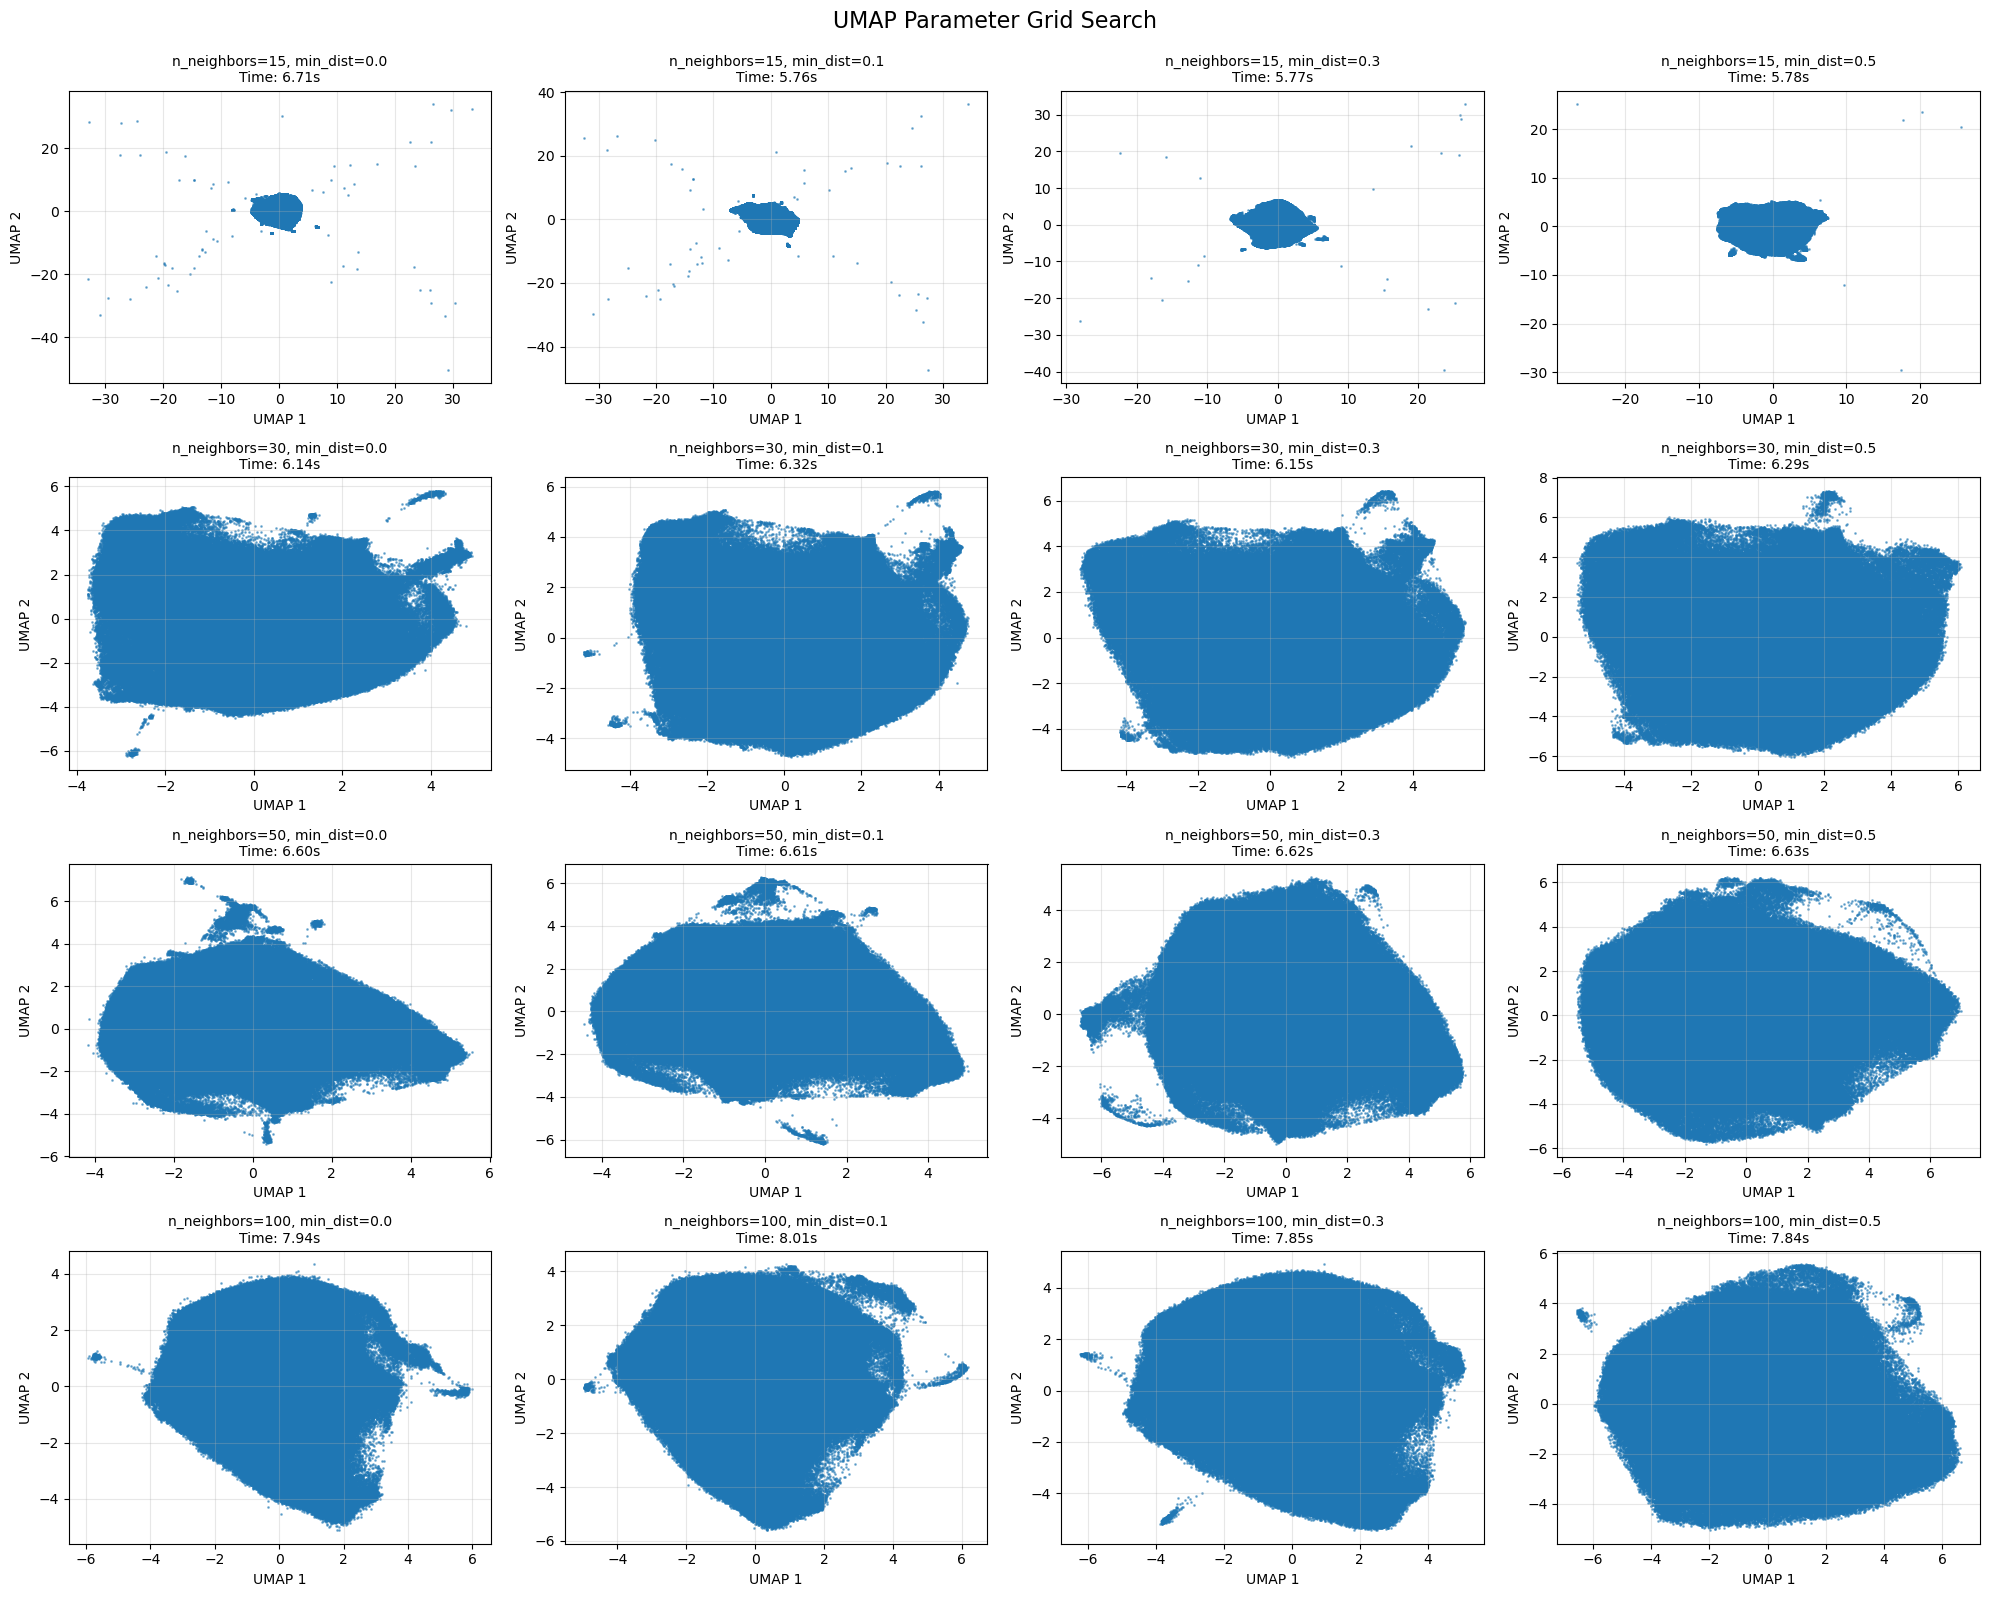

In [5]:
def compute_embedding(feats, use_gpu=True, topometry=False, n_neighbors=50, n_components=2, min_dist=0.1, random_state=42):
    """
    Compute 2D embedding using UMAP, optionally enhanced with TopOMetry.
    
    Parameters
    ----------
    feats : np.ndarray or pd.DataFrame
        Feature matrix (cells x features)
    use_gpu : bool
        Whether to use GPU UMAP (cuml) or CPU UMAP (umap-learn)
    topometry : bool
        Whether to apply TopOMetry graph enhancement first
    n_neighbors : int
        Number of neighbors for UMAP or TopOMetry graph
    n_components : int
        Number of UMAP dimensions
    min_dist : float
        UMAP min_dist parameter
    random_state : int
        Random seed for reproducibility
        
    Returns
    -------
    embedding : np.ndarray
        2D embedding of shape (n_samples, n_components)
    """
    # Optionally apply TopOMetry
    if topometry:
        print("Applying TopOMetry to enhance graph...")
        tg = tp.TopOGraph(
            n_eigs=50,
            base_knn=n_neighbors,
            graph_knn=n_neighbors,
            random_state=random_state,
            n_jobs=-1
        )
        tg.fit(feats)

        tg.transform(feats)
        
        # Extract the first kernel graph (similarity matrix)
        kernel_obj = list(tg.GraphKernelDict.values())[0]

        # Convert to distance: D = 1 - normalized_K
        K = kernel_obj.K.astype(float)
        # normalize to [0,1] if not already
        K = K / K.max()
        
        D = K.copy()                  # copy sparse matrix
        D.data = 1.0 - D.data         # subtract only the non-zero entries
        D.setdiag(0)
        D.eliminate_zeros() # Good practice to clean up
        D = D.toarray()
        
        data_for_umap = D
        metric = "precomputed"
        UMAP_Class = CPU_UMAP
    else:
        print("Running UMAP directly on features...")
        data_for_umap = feats
        metric = "cosine"
        UMAP_Class = GPU_UMAP if use_gpu else CPU_UMAP
    
    
    # Instantiate UMAP reducer
    reducer = UMAP_Class(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )

    

    # Fit and transform
    embedding = reducer.fit_transform(data_for_umap)
    
    return embedding

import numpy as np
import pandas as pd
from itertools import product
import time
import matplotlib.pyplot as plt

# Define parameter grid
param_grid = {
    'n_neighbors': [15, 30, 50, 100],
    'min_dist': [0.0, 0.1, 0.3, 0.5]
}

# Generate all combinations
param_combinations = list(product(
    param_grid['n_neighbors'],
    param_grid['min_dist']
))

print(f"Testing {len(param_combinations)} parameter combinations...\n")
print("=" * 80)

# Store results and embeddings
results = []
embeddings = []

# Test each combination
for i, (n_neighbors, min_dist) in enumerate(param_combinations, 1):
    print(f"\n[{i}/{len(param_combinations)}] Testing:")
    print(f"  n_neighbors={n_neighbors}, min_dist={min_dist}")
    
    start_time = time.time()
    
    try:
        # Compute embedding
        embedding = compute_embedding(
            feats,
            use_gpu=use_gpu,
            topometry=False,
            n_neighbors=n_neighbors,
            n_components=2,
            min_dist=min_dist,
            random_state=42
        )
        
        elapsed_time = time.time() - start_time
        
        # Calculate some basic metrics about the embedding
        embedding_std = np.std(embedding, axis=0)
        embedding_range = np.ptp(embedding, axis=0)  # peak-to-peak (max - min)
        
        results.append({
            'n_neighbors': n_neighbors,
            'min_dist': min_dist,
            'time_seconds': elapsed_time,
            'std_x': embedding_std[0],
            'std_y': embedding_std[1],
            'range_x': embedding_range[0],
            'range_y': embedding_range[1],
            'status': 'Success'
        })
        
        embeddings.append(embedding)
        
        print(f"  ✓ Completed in {elapsed_time:.2f}s")
        print(f"    Spread: X=[{embedding_range[0]:.2f}], Y=[{embedding_range[1]:.2f}]")
        
    except Exception as e:
        elapsed_time = time.time() - start_time
        results.append({
            'n_neighbors': n_neighbors,
            'min_dist': min_dist,
            'time_seconds': elapsed_time,
            'std_x': np.nan,
            'std_y': np.nan,
            'range_x': np.nan,
            'range_y': np.nan,
            'status': f'Failed: {str(e)}'
        })
        embeddings.append(None)
        print(f"  ✗ Failed: {str(e)}")

print("\n" + "=" * 80)
print("\nGRID SEARCH RESULTS:")
print("=" * 80)

# Convert to DataFrame for nice display
results_df = pd.DataFrame(results)

# Sort by time (fastest first) among successful runs
results_df_success = results_df[results_df['status'] == 'Success'].sort_values('time_seconds')
results_df_failed = results_df[results_df['status'] != 'Success']

print("\n✓ SUCCESSFUL RUNS (sorted by speed):")
print(results_df_success.to_string(index=False))

if len(results_df_failed) > 0:
    print("\n✗ FAILED RUNS:")
    print(results_df_failed.to_string(index=False))

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY:")
print(f"  Total runs: {len(results)}")
print(f"  Successful: {len(results_df_success)}")
print(f"  Failed: {len(results_df_failed)}")
if len(results_df_success) > 0:
    print(f"  Fastest run: {results_df_success.iloc[0]['time_seconds']:.2f}s")
    print(f"  Slowest run: {results_df_success.iloc[-1]['time_seconds']:.2f}s")
    print(f"  Average time: {results_df_success['time_seconds'].mean():.2f}s")

# Plot all embeddings in a grid
print("\n" + "=" * 80)
print("VISUALIZING EMBEDDINGS...")
print("=" * 80)

n_rows = len(param_grid['n_neighbors'])
n_cols = len(param_grid['min_dist'])

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
fig.suptitle('UMAP Parameter Grid Search', fontsize=16, y=0.995)

for idx, ((n_neighbors, min_dist), embedding, result) in enumerate(zip(param_combinations, embeddings, results)):
    row = idx // n_cols
    col = idx % n_cols
    
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    if embedding is not None:
        # Plot the embedding
        scatter = ax.scatter(embedding[:, 0], embedding[:, 1], 
                           s=1, alpha=0.5, rasterized=True)
        
        ax.set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}\n"
                    f"Time: {result['time_seconds']:.2f}s", 
                    fontsize=10)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'FAILED', 
               ha='center', va='center', fontsize=20, color='red',
               transform=ax.transAxes)
        ax.set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}\n"
                    f"Status: {result['status']}", 
                    fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

### Calculate actual UMAP embeddings
Choose n_neighbors and min_dist from the plot above!

In [6]:
embedding = compute_embedding(feats, n_neighbors=50, min_dist=0.5, use_gpu=use_gpu, topometry=False)

# 'df_emb_list' now only contains metadata (t, x, y, track_id)
df_emb_list['umap_1'] = embedding[:, 0]
df_emb_list['umap_2'] = embedding[:, 1]

print("\nUMAP coordinates added to df_emb_list.")

Running UMAP directly on features...
[2025-11-26 13:23:47.565] [CUML] [info] build_algo set to brute_force_knn because random_state is given
Computed UMAP embedding of shape: (390354, 2)


In [5]:
df_emb_list = df_final.copy()

## Sample subset
Currently not working

In [8]:
# --- Configuration ---
SAMPLE_MODE = "sample_per_track"   # options: "sample_tracks" or "sample_per_track"
N_TRACKS_TO_SAMPLE = 200        # used only in "sample_tracks" mode
N_SAMPLES_PER_TRACK = 20        # used only in "sample_per_track" mode

# --- Subsetting Logic ---
unique_track_ids = df_emb_list['track_id'].unique()

if SAMPLE_MODE == "sample_tracks":
    # --- Mode 1: sample a subset of tracks ---
    n_actual_sample = min(N_TRACKS_TO_SAMPLE, len(unique_track_ids))
    sampled_ids = pd.Series(unique_track_ids).sample(
        n=n_actual_sample,
        random_state=42
    ).tolist()
    df_subset = df_emb_list[df_emb_list['track_id'].isin(sampled_ids)].copy()

elif SAMPLE_MODE == "sample_per_track":
    # --- Mode 2: sample n examples per track ---
    df_subset = (
        df_emb_list
        .groupby("track_id", group_keys=False)
        .apply(lambda g: g.sample(n=min(N_SAMPLES_PER_TRACK, len(g)), random_state=42))
        .reset_index(drop=True)
    )

else:
    raise ValueError(f"Invalid SAMPLE_MODE '{SAMPLE_MODE}'. Choose 'sample_tracks' or 'sample_per_track'.")

# --- Summary ---
print(f"Sampling mode: {SAMPLE_MODE}")
print(f"Original DataFrame Size: {df_emb_list.shape[0]} rows")
print(f"Subset DataFrame Size: {df_subset.shape[0]} rows")
print(f"Total Unique Tracks in Subset: {df_subset['track_id'].nunique()}")


Sampling mode: sample_per_track
Original DataFrame Size: 390354 rows
Subset DataFrame Size: 100923 rows
Total Unique Tracks in Subset: 2326


/tmp/ipykernel_2122798/189899440.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(N_SAMPLES_PER_TRACK, len(g)), random_state=42))


## Additional UMAP representations

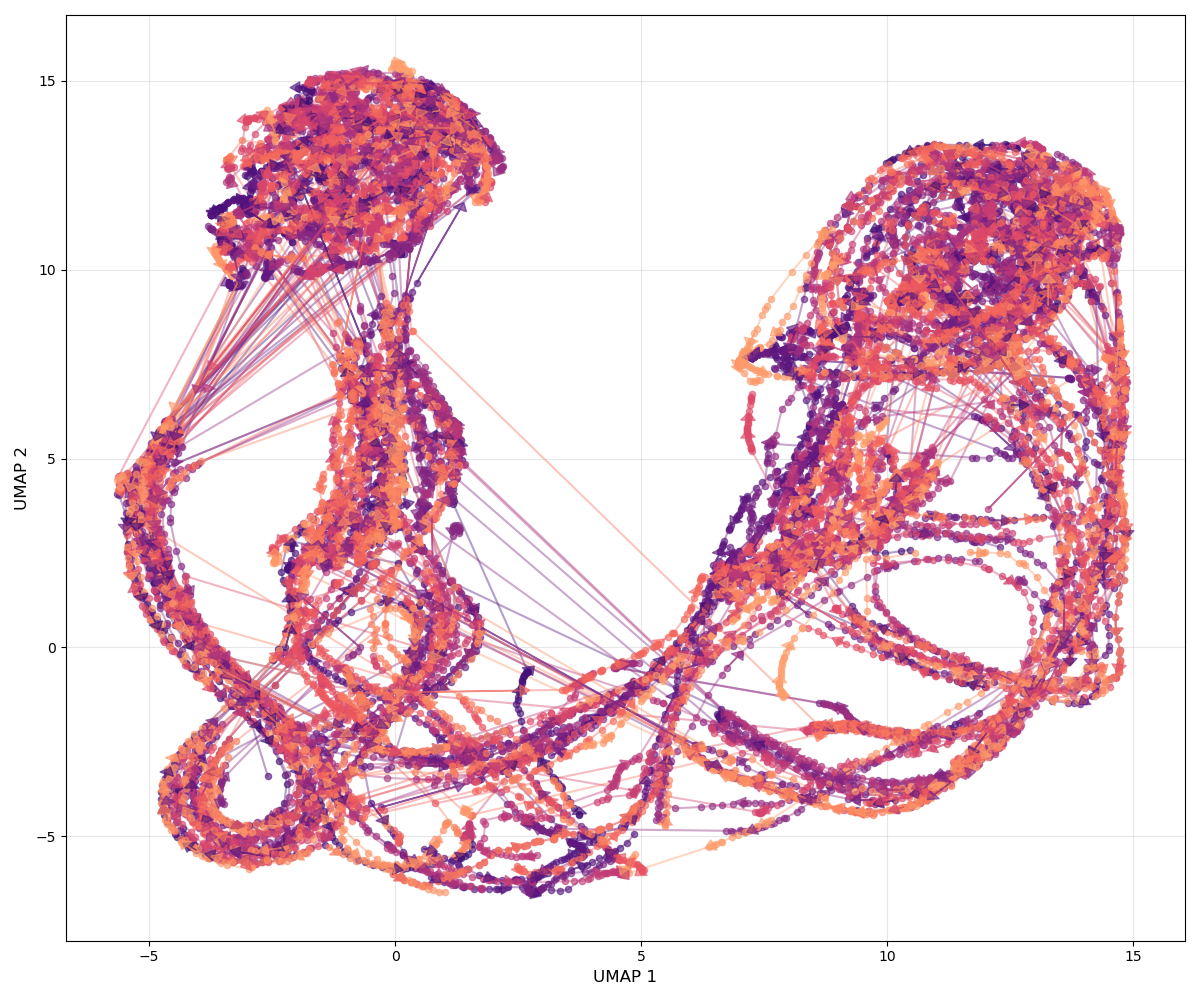

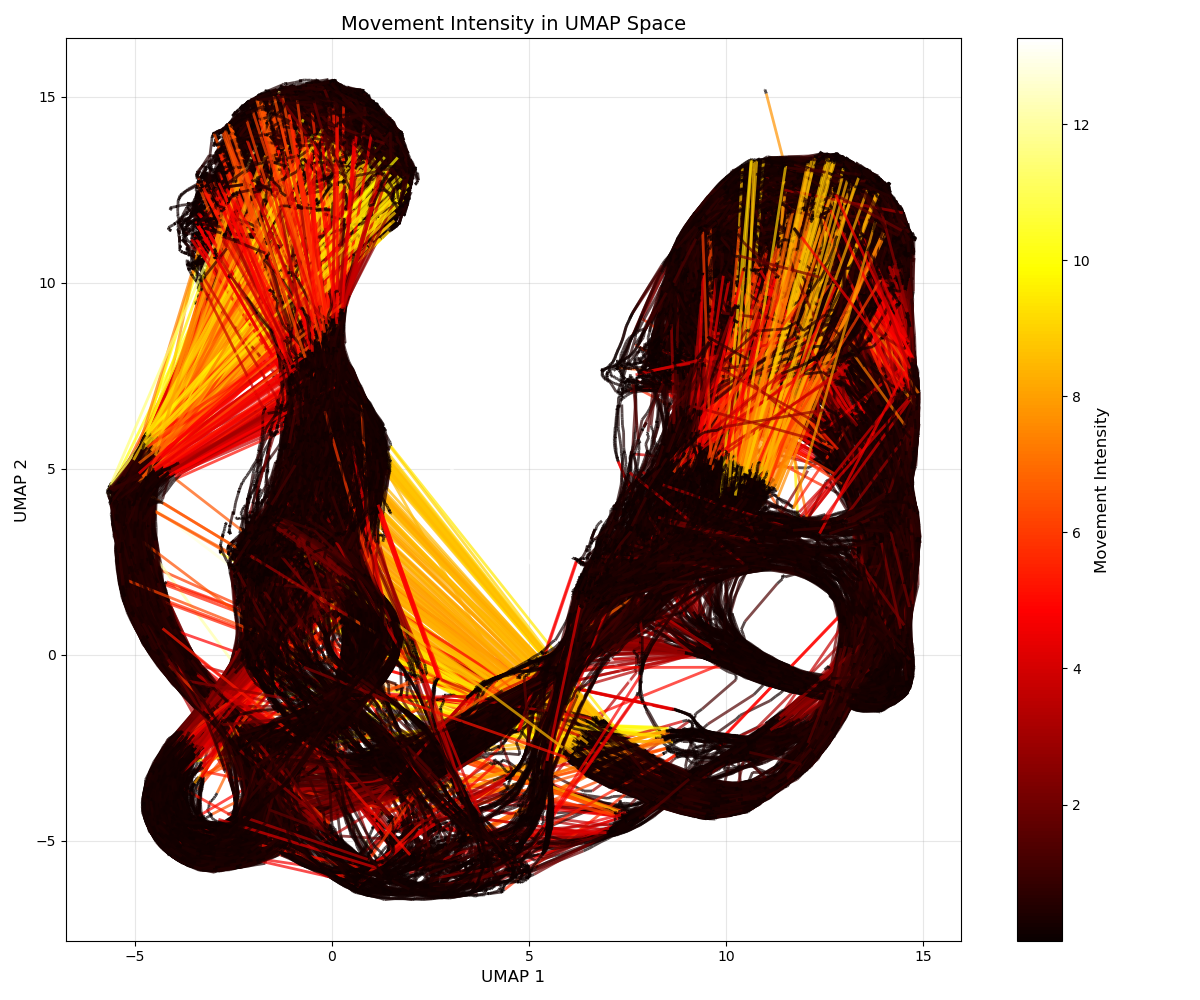

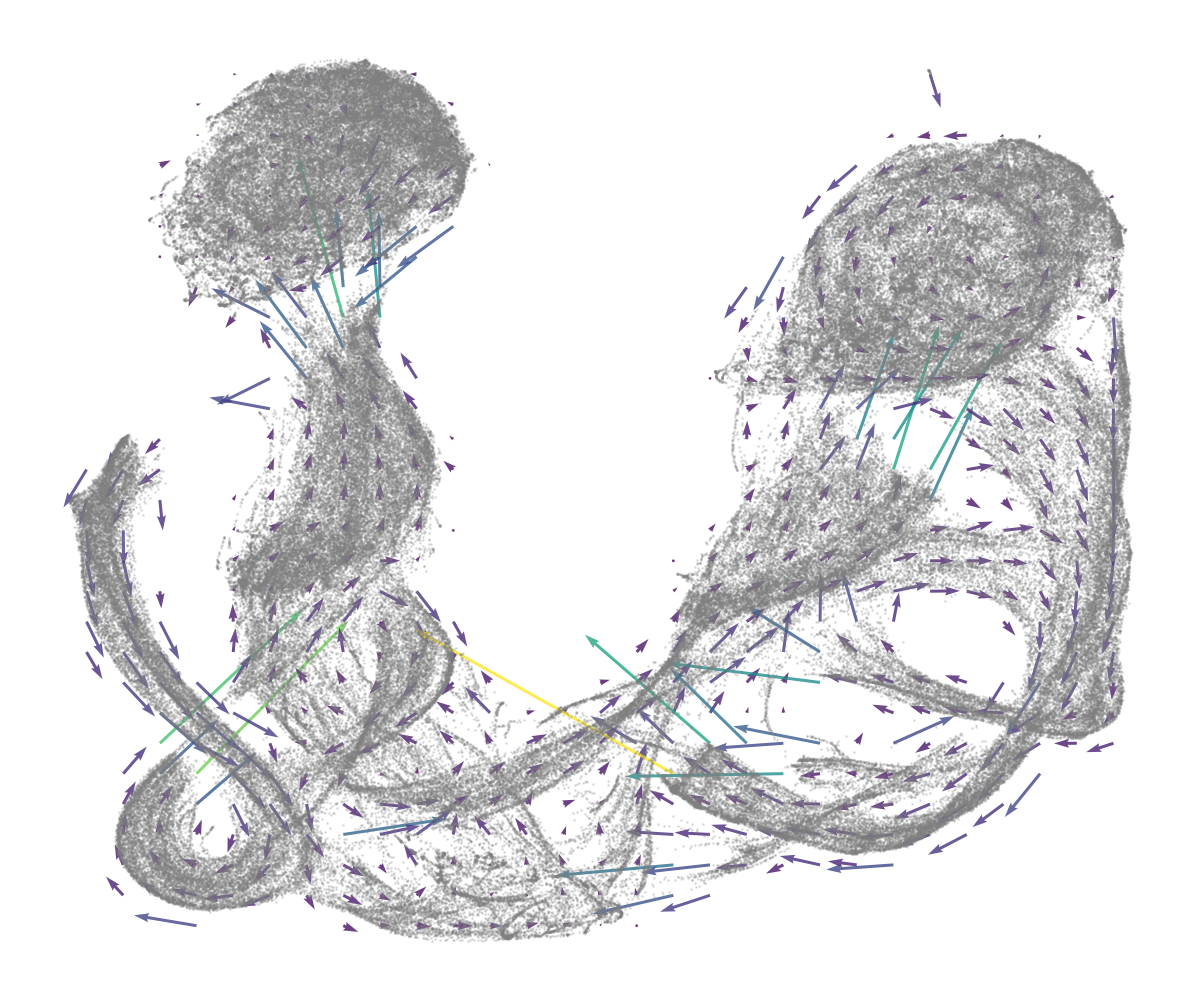

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_track_trajectories(df, umap_col=['umap_1', 'umap_2'], track_id_col='track_id',
                            time_col='t', figsize=(12, 10), max_tracks=None,
                            show_arrows=True, show_points=True):
    """
    Plot UMAP with trajectories showing temporal connections within tracks.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique tracks
    unique_tracks = df[track_id_col].unique()
    if max_tracks is not None:
        unique_tracks = np.random.choice(unique_tracks, max_tracks)
    
    # Color map for tracks
    #colors = plt.cm.tab20(np.linspace(0, 1, len(unique_tracks)))
    cmap = plt.cm.magma 
    colors = cmap(np.linspace(0.2, 0.8, len(unique_tracks)))
    
    for track_idx, track_id in enumerate(unique_tracks):
        track_data = df[df[track_id_col] == track_id].copy()
        
        # Sort by time
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        # Plot points
        if show_points:
            ax.scatter(x, y, c=[colors[track_idx]], s=20, alpha=0.6, zorder=2)
        
        # Plot trajectory lines
        if len(x) > 1:
            ax.plot(x, y, c=colors[track_idx], alpha=0.4, linewidth=1.5, zorder=1)
            
            # Add arrows to show direction
            if show_arrows:
                for i in range(0, len(x)-1, max(1, len(x)//5)):  # Show ~5 arrows per track
                    dx = x[i+1] - x[i]
                    dy = y[i+1] - y[i]
                    ax.arrow(x[i], y[i], dx*0.8, dy*0.8, 
                            head_width=0.3, head_length=0.2,
                            fc=colors[track_idx], ec=colors[track_idx],
                            alpha=0.6, zorder=3)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    #ax.set_title('Track Trajectories in UMAP Space', fontsize=14)
    #ax.axis('off')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_movement_intensity(df, umap_col=['umap_1', 'umap_2'], track_id_col='track_id',
                            time_col='t', figsize=(12, 10)):
    """
    Visualize movement intensity (speed) along trajectories using color gradients.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    unique_tracks = df[track_id_col].unique()
    
    all_displacements = []
    
    # First pass: collect all displacements to get global min/max
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        displacements = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
        all_displacements.extend(displacements)
    
    # Get global min/max for consistent coloring
    if len(all_displacements) > 0:
        vmin, vmax = np.min(all_displacements), np.max(all_displacements)
    else:
        vmin, vmax = 0, 1
    
    norm = plt.Normalize(vmin, vmax)
    
    # Second pass: plot with consistent coloring
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        # Calculate movement intensity (displacement between consecutive points)
        displacements = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
        
        # Create line segments with colors based on displacement
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, cmap='hot', norm=norm, alpha=0.7, linewidth=2)
        lc.set_array(displacements)
        ax.add_collection(lc)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='hot', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Movement Intensity', fontsize=12)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('Movement Intensity in UMAP Space', fontsize=14)
    ax.autoscale()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_vector_field(df, umap_col=['umap_1', 'umap_2'], track_id_col='track_id',
                     time_col='t', grid_size=20, figsize=(12, 10)):
    """
    Create a vector field showing dominant movement directions in different regions.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Collect all movements
    movements = []
    
    unique_tracks = df[track_id_col].unique()
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        # Calculate movements
        for i in range(len(x) - 1):
            movements.append({
                'x': x[i],
                'y': y[i],
                'dx': x[i+1] - x[i],
                'dy': y[i+1] - y[i]
            })
    
    movements_df = pd.DataFrame(movements)
    
    # Create grid
    x_min, x_max = movements_df['x'].min(), movements_df['x'].max()
    y_min, y_max = movements_df['y'].min(), movements_df['y'].max()
    
    x_bins = np.linspace(x_min, x_max, grid_size)
    y_bins = np.linspace(y_min, y_max, grid_size)
    
    # Calculate average movement in each grid cell
    grid_x = []
    grid_y = []
    grid_dx = []
    grid_dy = []
    grid_intensity = []
    
    for i in range(len(x_bins) - 1):
        for j in range(len(y_bins) - 1):
            mask = ((movements_df['x'] >= x_bins[i]) & 
                   (movements_df['x'] < x_bins[i+1]) &
                   (movements_df['y'] >= y_bins[j]) & 
                   (movements_df['y'] < y_bins[j+1]))
            
            if mask.sum() > 0:
                grid_x.append((x_bins[i] + x_bins[i+1]) / 2)
                grid_y.append((y_bins[j] + y_bins[j+1]) / 2)
                grid_dx.append(movements_df.loc[mask, 'dx'].mean())
                grid_dy.append(movements_df.loc[mask, 'dy'].mean())
                
                # Calculate intensity (magnitude)
                intensity = np.sqrt(grid_dx[-1]**2 + grid_dy[-1]**2)
                grid_intensity.append(intensity)
    
    grid_x = np.array(grid_x)
    grid_y = np.array(grid_y)
    grid_dx = np.array(grid_dx)
    grid_dy = np.array(grid_dy)
    grid_intensity = np.array(grid_intensity)
    
    # Plot vector field
    quiver = ax.quiver(grid_x, grid_y, grid_dx, grid_dy, grid_intensity,
                      cmap='viridis', scale=None, scale_units='xy',
                      angles='xy', alpha=0.8)
    
    # Add colorbar
    #cbar = plt.colorbar(quiver, ax=ax)
    #cbar.set_label('Movement Magnitude', fontsize=12)
    
    # Overlay scatter plot of all points
    all_x = movements_df['x'].values
    all_y = movements_df['y'].values
    ax.scatter(all_x, all_y, s=1, c='gray', alpha=0.2, zorder=1)
    
    #ax.set_xlabel('UMAP 1', fontsize=12)
    #ax.set_ylabel('UMAP 2', fontsize=12)
    #ax.set_title('Movement Vector Field in UMAP Space', fontsize=14)
    #ax.grid(True, alpha=0.3)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


# Example usage with your dataframe:
# 1. Basic trajectory plot (limit to 20 tracks for clarity)
plot_track_trajectories(df_emb_list, max_tracks=400)

# 2. Movement intensity visualization
plot_movement_intensity(df_emb_list)

# 3. Vector field showing dominant directions
plot_vector_field(df_emb_list, grid_size=30)

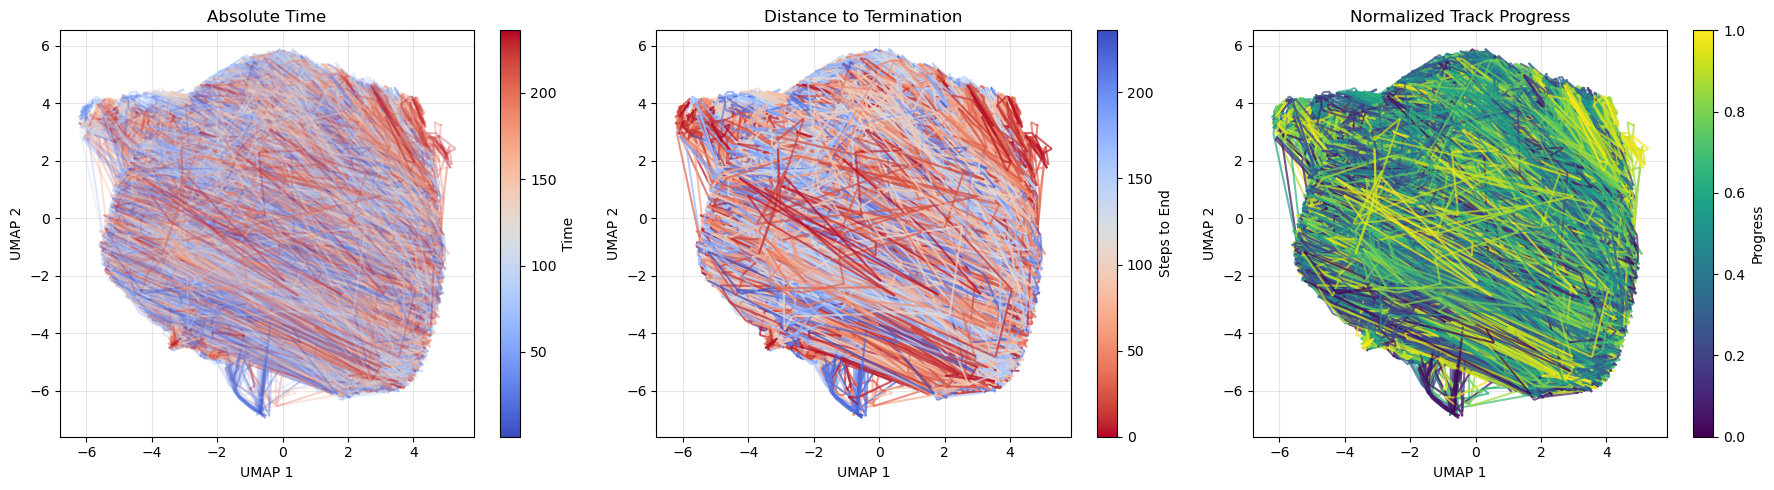

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
alpha = 0.1
def plot_trajectories_by_time(df, umap_col=['umap_1', 'umap_2'], track_id_col='track_id',
                               time_col='t', figsize=(12, 10), max_tracks=None,
                               show_points=False):
    """
    Plot trajectories colored by time (early = blue, late = red).
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique tracks
    unique_tracks = df[track_id_col].unique()
    if max_tracks is not None:
        unique_tracks = unique_tracks[:max_tracks]
    
    # Get global time range for consistent coloring
    t_min = df[time_col].min()
    t_max = df[time_col].max()
    norm = plt.Normalize(t_min, t_max)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        t = track_data[time_col].values
        
        if len(x) < 2:
            continue
        
        # Create line segments
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Use time values for coloring (average of segment endpoints)
        segment_times = (t[:-1] + t[1:]) / 2
        
        lc = LineCollection(segments, cmap='coolwarm', norm=norm, alpha=0.7, linewidth=2)
        lc.set_array(segment_times)
        ax.add_collection(lc)
        
        # Optionally plot points
        if show_points:
            ax.scatter(x, y, c=t, cmap='coolwarm', norm=norm, s=10, alpha=0.5, zorder=2)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Time', fontsize=12)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('Trajectories Colored by Time (Blue=Early, Red=Late)', fontsize=14)
    ax.autoscale()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_trajectories_by_distance_to_end(df, umap_col=['umap_1', 'umap_2'], 
                                         track_id_col='track_id', time_col='t',
                                         figsize=(12, 10), max_tracks=None,
                                         show_points=False):
    """
    Plot trajectories colored by distance to termination (far = blue, near = red).
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique tracks
    unique_tracks = df[track_id_col].unique()
    if max_tracks is not None:
        unique_tracks = unique_tracks[:max_tracks]
    
    # Calculate max steps to termination across all tracks for normalization
    max_steps_to_term = 0
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        max_steps_to_term = max(max_steps_to_term, len(track_data))
    
    norm = plt.Normalize(0, max_steps_to_term)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        # Calculate steps to termination for each point
        n_points = len(x)
        steps_to_term = np.arange(n_points, 0, -1)
        
        # Create line segments
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Use steps to termination for coloring (average of segment endpoints)
        segment_steps = (steps_to_term[:-1] + steps_to_term[1:]) / 2
        
        lc = LineCollection(segments, cmap='coolwarm_r', norm=norm, alpha=0.7, linewidth=2)
        lc.set_array(segment_steps)
        ax.add_collection(lc)
        
        # Optionally plot points
        if show_points:
            ax.scatter(x, y, c=steps_to_term, cmap='coolwarm_r', norm=norm, 
                      s=10, alpha=0.5, zorder=2)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Steps to Termination', fontsize=12)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('Trajectories Colored by Distance to Termination (Blue=Far, Red=Near)', fontsize=14)
    ax.autoscale()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_trajectories_normalized_time(df, umap_col=['umap_1', 'umap_2'], 
                                      track_id_col='track_id', time_col='t',
                                      figsize=(12, 10), max_tracks=None,
                                      show_points=False):
    """
    Plot trajectories colored by normalized time within each track (0=start, 1=end).
    This is useful when tracks have different lengths.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique tracks
    unique_tracks = df[track_id_col].unique()
    if max_tracks is not None:
        unique_tracks = unique_tracks[:max_tracks]
    
    norm = plt.Normalize(0, 1)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        # Get coordinates
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        # Normalize time within track (0 to 1)
        n_points = len(x)
        normalized_time = np.linspace(0, 1, n_points)
        
        # Create line segments
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Use normalized time for coloring
        segment_times = (normalized_time[:-1] + normalized_time[1:]) / 2
        
        lc = LineCollection(segments, cmap='viridis', norm=norm, alpha=0.7, linewidth=2)
        lc.set_array(segment_times)
        ax.add_collection(lc)
        
        # Optionally plot points
        if show_points:
            ax.scatter(x, y, c=normalized_time, cmap='viridis', norm=norm, 
                      s=10, alpha=0.5, zorder=2)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Normalized Track Progress', fontsize=12)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('Trajectories Colored by Normalized Time (Purple=Start, Yellow=End)', fontsize=14)
    ax.autoscale()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_all_temporal_views(df, umap_col=['umap_1', 'umap_2'], 
                            track_id_col='track_id', time_col='t',
                            max_tracks=50, figsize=(18, 5)):
    """
    Create a 3-panel figure showing all temporal coloring schemes.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Get unique tracks
    unique_tracks = df[track_id_col].unique()
    if max_tracks is not None:
        unique_tracks = unique_tracks[:max_tracks]
    
    # Panel 1: Absolute time
    t_min = df[time_col].min()
    t_max = df[time_col].max()
    norm_time = plt.Normalize(t_min, t_max)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        t = track_data[time_col].values
        
        if len(x) < 2:
            continue
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segment_times = (t[:-1] + t[1:]) / 2
        
        lc = LineCollection(segments, cmap='coolwarm', norm=norm_time, alpha=0.3, linewidth=1.5)
        lc.set_array(segment_times)
        axes[0].add_collection(lc)
    
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm_time)
    sm.set_array([])
    plt.colorbar(sm, ax=axes[0], label='Time')
    axes[0].set_title('Absolute Time')
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    axes[0].autoscale()
    axes[0].grid(True, alpha=0.3)
    
    # Panel 2: Distance to termination
    max_steps = 0
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        max_steps = max(max_steps, len(track_data))
    
    norm_steps = plt.Normalize(0, max_steps)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        n_points = len(x)
        steps_to_term = np.arange(n_points, 0, -1)
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segment_steps = (steps_to_term[:-1] + steps_to_term[1:]) / 2
        
        lc = LineCollection(segments, cmap='coolwarm_r', norm=norm_steps, alpha=0.7, linewidth=1.5)
        lc.set_array(segment_steps)
        axes[1].add_collection(lc)
    
    sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm_steps)
    sm.set_array([])
    plt.colorbar(sm, ax=axes[1], label='Steps to End')
    axes[1].set_title('Distance to Termination')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].autoscale()
    axes[1].grid(True, alpha=0.3)
    
    # Panel 3: Normalized time
    norm_norm = plt.Normalize(0, 1)
    
    for track_id in unique_tracks:
        track_data = df[df[track_id_col] == track_id].copy()
        track_data = track_data.sort_values(time_col)
        
        if isinstance(umap_col, list):
            x = track_data[umap_col[0]].values
            y = track_data[umap_col[1]].values
        else:
            coords = np.array(track_data[umap_col].tolist())
            x, y = coords[:, 0], coords[:, 1]
        
        if len(x) < 2:
            continue
        
        n_points = len(x)
        normalized_time = np.linspace(0, 1, n_points)
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        segment_times = (normalized_time[:-1] + normalized_time[1:]) / 2
        
        lc = LineCollection(segments, cmap='viridis', norm=norm_norm, alpha=0.7, linewidth=1.5)
        lc.set_array(segment_times)
        axes[2].add_collection(lc)
    
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm_norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes[2], label='Progress')
    axes[2].set_title('Normalized Track Progress')
    axes[2].set_xlabel('UMAP 1')
    axes[2].set_ylabel('UMAP 2')
    axes[2].autoscale()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Example usage:

# Individual plots
#plot_trajectories_by_time(df_emb_list, max_tracks=50)
#plot_trajectories_by_distance_to_end(df_emb_list, max_tracks=50)
#plot_trajectories_normalized_time(df_emb_list, max_tracks=50)

# All three in one figure for comparison
plot_all_temporal_views(df_emb_list, max_tracks=1000)